<a href="https://colab.research.google.com/github/jacobgreen4477/The-4th-ETRI-AI-Human-Understanding-Competition/blob/main/dacon_etri_lifelog_model_vF1_0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> title : 제 4회 ETRI 휴먼이해 인공지능 논문경진대회 <br>
> author : hjy,byc <br>

### 📦 라이브러리

In [ ]:
! pip install haversine >/dev/null
! pip install optuna  >/dev/null
! pip install category_encoders >/dev/null
! pip install tabpfn  >/dev/null
! pip install catboost >/dev/null
! pip install torchmetrics >/dev/null

In [ ]:
# 기본 모듈
import os
import sys
import re
import ast
import glob
import random
import warnings
from collections import Counter
from math import radians, cos, sin, asin, sqrt
from functools import reduce
from datetime import datetime, timedelta, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 머신러닝
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from category_encoders import TargetEncoder
from lightgbm import LGBMClassifier, log_evaluation, early_stopping
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from tabpfn import TabPFNClassifier
from sklearn.inspection import permutation_importance

# PyTorch
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Hugging Face
from huggingface_hub import login
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    LlamaTokenizer,
    LlamaForCausalLM,
    LlamaForSequenceClassification
)

# PEFT (Parameter-Efficient Fine-Tuning)
from peft import (
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    TaskType
)

# Evaluation & Utilities
from torchmetrics import Accuracy

# 기타
from tqdm import tqdm
from tqdm.auto import tqdm as auto_tqdm  # 필요 시 구분
from scipy.stats import entropy
from haversine import haversine
from io import StringIO
import gc

# wandb
import wandb
wandb.login(key="5fa8dfb2c5be3c888bfe0101437a8fa22fbdf0e0")
wandb.init(project="etri_lifelog", entity="byc3230")

# 옵션
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%0.4f' % x)

# 기타
warnings.filterwarnings('ignore')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: byc3230 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
string = """
subject_id,sleep_date
id01,2024-07-24
id01,2024-08-26
id01,2024-08-28
id01,2024-08-29
id02,2024-08-23
id02,2024-09-24
id02,2024-09-26
id02,2024-09-27
id03,2024-08-30
id03,2024-09-01
id03,2024-09-02
id03,2024-09-06
id04,2024-09-03
id04,2024-10-10
id04,2024-10-12
id04,2024-10-13
id05,2024-10-19
id05,2024-10-23
id05,2024-10-24
id05,2024-10-27
id06,2024-07-25
id06,2024-07-26
id06,2024-07-27
id06,2024-07-30
id07,2024-07-07
id07,2024-08-02
id07,2024-08-04
id07,2024-08-05
id08,2024-08-28
id08,2024-08-29
id08,2024-08-30
id08,2024-09-02
id09,2024-08-02
id09,2024-08-31
id09,2024-09-02
id09,2024-09-03
id10,2024-08-28
id10,2024-08-30
id10,2024-08-31
id10,2024-09-03
"""

# DataFrame 생성
valid_ids = pd.read_csv(StringIO(string), sep=',')
valid_ids['pk'] = valid_ids['subject_id']+valid_ids['sleep_date']

In [ ]:
string = """
subject_id	sleep_date
id01	2024-07-24
id01	2024-07-27
id01	2024-08-18
id01	2024-08-19
id01	2024-08-20
id01	2024-08-21
id01	2024-08-22
id01	2024-08-24
id01	2024-08-25
id01	2024-08-26
id01	2024-08-27
id01	2024-08-28
id01	2024-08-29
id01	2024-08-30
id02	2024-08-23
id02	2024-08-24
id02	2024-09-16
id02	2024-09-17
id02	2024-09-19
id02	2024-09-20
id02	2024-09-21
id02	2024-09-22
id02	2024-09-23
id02	2024-09-24
id02	2024-09-25
id02	2024-09-26
id02	2024-09-27
id02	2024-09-28
id03	2024-08-30
id03	2024-09-01
id03	2024-09-02
id03	2024-09-03
id03	2024-09-05
id03	2024-09-06
id03	2024-09-07
id04	2024-09-03
id04	2024-09-04
id04	2024-09-05
id04	2024-09-06
id04	2024-09-07
id04	2024-09-08
id04	2024-09-09
id04	2024-10-08
id04	2024-10-09
id04	2024-10-10
id04	2024-10-11
id04	2024-10-12
id04	2024-10-13
id04	2024-10-14
id05	2024-10-19
id05	2024-10-23
id05	2024-10-24
id05	2024-10-25
id05	2024-10-26
id05	2024-10-27
id05	2024-10-28
id06	2024-07-25
id06	2024-07-26
id06	2024-07-27
id06	2024-07-28
id06	2024-07-29
id06	2024-07-30
id06	2024-07-31
id07	2024-07-07
id07	2024-07-08
id07	2024-07-09
id07	2024-07-10
id07	2024-07-11
id07	2024-07-12
id07	2024-07-13
id07	2024-07-30
id07	2024-08-01
id07	2024-08-02
id07	2024-08-03
id07	2024-08-04
id07	2024-08-05
id07	2024-08-06
id08	2024-08-28
id08	2024-08-29
id08	2024-08-30
id08	2024-08-31
id08	2024-09-01
id08	2024-09-02
id08	2024-09-04
id09	2024-08-02
id09	2024-08-22
id09	2024-08-23
id09	2024-08-24
id09	2024-08-25
id09	2024-08-27
id09	2024-08-28
id09	2024-08-29
id09	2024-08-30
id09	2024-08-31
id09	2024-09-01
id09	2024-09-02
id09	2024-09-03
id09	2024-09-04
id10	2024-08-28
id10	2024-08-30
id10	2024-08-31
id10	2024-09-01
id10	2024-09-02
id10	2024-09-03
id10	2024-09-06
"""

# DataFrame 생성
valid_ids2 = pd.read_csv(StringIO(string), sep='\t')
valid_ids2['pk'] = valid_ids2['subject_id']+valid_ids2['sleep_date']

In [ ]:
print(len(valid_ids))
print(len(valid_ids2))

40
105


### 📦 데이터 읽기

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')

path = '/content/drive/MyDrive/data/ch2025_data_items/share/'

# [1]공통
# train = pd.read_parquet(f'{path}train_63775_v2.parquet')
# test = pd.read_parquet(f'{path}test_63775_v2.parquet')

# [2]version2 train,test 데이터셋 by 현종열
train = pd.read_parquet(f'{path}train_hjy_0603_v1.parquet')
test = pd.read_parquet(f'{path}test_hjy_0603_v1.parquet')

# [3]QWEN3 8B 활용한 결측처리 (대상: mScreenStatus)
mScreenStatus_llm = pd.read_excel(f'{path}mScreenStatus_llm결측값생성후파생변수생성_20250609_v1.xlsx')
feats = ['sleep_time', 'wake_time', 'sleep_duration_min', 'avg_sleep_time', 'avg_wake_time', 'avg_sleep_duration', 'sleep_time_diff', 'wake_time_diff', 'sleep_duration_diff', 'sleep_time_ratio', 'wake_time_ratio', 'sleep_duration_ratio', 'sleep_time_lag1', 'wake_time_lag1', 'sleep_duration_lag1', 'sleep_time_diff_lag1', 'wake_time_diff_lag1', 'sleep_duration_diff_lag1', 'sleep_time_ratio_lag1', 'wake_time_ratio_lag1', 'sleep_duration_ratio_lag1', 'sleep_time_lag2', 'wake_time_lag2', 'sleep_duration_lag2', 'sleep_time_diff_lag2', 'wake_time_diff_lag2', 'sleep_duration_diff_lag2', 'sleep_time_ratio_lag2', 'wake_time_ratio_lag2', 'sleep_duration_ratio_lag2', 'sleep_time_mean2d', 'wake_time_mean2d', 'sleep_duration_min_mean2d', 'sleep_time_diff_mean2d', 'wake_time_diff_mean2d', 'sleep_duration_diff_mean2d', 'sleep_time_ratio_mean2d', 'wake_time_ratio_mean2d', 'sleep_duration_ratio_mean2d', 'sleep_time_std2d', 'wake_time_std2d', 'sleep_duration_min_std2d', 'sleep_time_diff_std2d', 'wake_time_diff_std2d', 'sleep_duration_diff_std2d', 'sleep_time_ratio_std2d', 'wake_time_ratio_std2d', 'sleep_duration_ratio_std2d', 'sleep_time_mean3d', 'wake_time_mean3d', 'sleep_duration_min_mean3d', 'sleep_time_diff_mean3d', 'wake_time_diff_mean3d', 'sleep_duration_diff_mean3d', 'sleep_time_ratio_mean3d', 'wake_time_ratio_mean3d', 'sleep_duration_ratio_mean3d', 'sleep_time_std3d', 'wake_time_std3d', 'sleep_duration_min_std3d', 'sleep_time_diff_std3d', 'wake_time_diff_std3d', 'sleep_duration_diff_std3d', 'sleep_time_ratio_std3d', 'wake_time_ratio_std3d', 'sleep_duration_ratio_std3d', 'sleep_time_mean5d', 'wake_time_mean5d', 'sleep_duration_min_mean5d', 'sleep_time_diff_mean5d', 'wake_time_diff_mean5d', 'sleep_duration_diff_mean5d', 'sleep_time_ratio_mean5d', 'wake_time_ratio_mean5d', 'sleep_duration_ratio_mean5d', 'sleep_time_std5d', 'wake_time_std5d', 'sleep_duration_min_std5d', 'sleep_time_diff_std5d', 'wake_time_diff_std5d', 'sleep_duration_diff_std5d', 'sleep_time_ratio_std5d', 'wake_time_ratio_std5d', 'sleep_duration_ratio_std5d', 'sleep_time_mean7d', 'wake_time_mean7d', 'sleep_duration_min_mean7d', 'sleep_time_diff_mean7d', 'wake_time_diff_mean7d', 'sleep_duration_diff_mean7d', 'sleep_time_ratio_mean7d', 'wake_time_ratio_mean7d', 'sleep_duration_ratio_mean7d', 'sleep_time_std7d', 'wake_time_std7d', 'sleep_duration_min_std7d', 'sleep_time_diff_std7d', 'wake_time_diff_std7d', 'sleep_duration_diff_std7d', 'sleep_time_ratio_std7d', 'wake_time_ratio_std7d', 'sleep_duration_ratio_std7d', 'weekday_avg_sleep', 'sleep_duration_weekday_avg_diff', 'sleep_duration_weekday_avg_div']
drop_features = [i for i in feats if i in train.columns]
train = train.drop(columns=drop_features)
train = train.merge(mScreenStatus_llm,on=['subject_id','lifelog_date'],how='left')
test = test.drop(columns=drop_features)
test = test.merge(mScreenStatus_llm,on=['subject_id','lifelog_date'],how='left')

# [4]Reference file
reference_file = '/content/drive/MyDrive/data/ch2025_data_items/share/submissions/submission_top1_0.6492.csv'
ref_df = pd.read_csv(reference_file)
ptest = test.copy()
ptest['lifelog_date'] = ptest['lifelog_date'].astype(str)
ptest = ptest.drop(columns=['Q1','Q2','Q3','S1','S2','S3'])
ptest = ptest.merge(ref_df,on=['subject_id','sleep_date','lifelog_date'],how='left')
train = pd.concat([train,ptest]).reset_index(drop=True)
print(f'shae of train: {train.shape}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
shae of train: (700, 332)


In [ ]:
def sanitize_column_names(df):
    df.columns = df.columns.str.replace(r'[^\w]', '_', regex=True)
    return df

train = sanitize_column_names(train)
test = sanitize_column_names(test)

drop_featurs = [
 'Unnamed__0'
,'light_week_type_lag1'
,'week_type'
,'week_type_lag1'
,'activehour_top_bssid'
,'beforebed_top_bssid'
]
drop_featurs = [i for i in drop_featurs if i in train.columns]
train = train.drop(columns=drop_featurs)
test = test.drop(columns=drop_featurs)

# check
print('# train  shape:',train.shape)
print('# test   shape:',test.shape)

# train  shape: (700, 327)
# test   shape: (250, 327)


In [ ]:
valid_ids.head(1)

subject_id  sleep_date              pk
0       id01  2024-07-24  id012024-07-24

In [ ]:
ptest['pk'] = ptest['subject_id']+ptest['sleep_date']
valid_ids = pd.concat([valid_ids,ptest[['subject_id','sleep_date','pk']]]).reset_index(drop=True)

### ============================

### run_basemodel

In [64]:
def run_basemodel(train, test, valid_ids, common_params, n_splits, n_repeats, random_state=42):

    lgb_A = 0.333
    xgb_B = 0.334
    tab_C = 0.333

    train_df = train.copy()
    test_df = test.copy()

    submission_final = test_df[['subject_id', 'sleep_date', 'lifelog_date']].copy()
    submission_final['lifelog_date'] = pd.to_datetime(submission_final['lifelog_date']).dt.date

    # 타겟
    targets_binary = ['Q1', 'Q2', 'Q3', 'S2', 'S3']
    targets_binary_name = ['기상직후수면질','취침전신체적피로','취침전스트레스','수면효율','수면잠들기시간']
    target_multiclass = 'S1'
    all_targets = targets_binary + [target_multiclass]

    # 노이즈 수준 설정
    def add_noise(series, noise_level, seed=3):
        rng = np.random.default_rng(seed)
        return series * (1 + noise_level * rng.standard_normal(len(series)))

    noise_level = 0.015  # 필요에 따라 조정

    # 타겟인코딩
    for tgt in all_targets:

      encoder_feats = ['subject_id','month','weekend'] # 'weekday', 'subject_id','month','weekend'

      #### 타겟인코딩1

      subject_mean = train_df.groupby(encoder_feats)[tgt].mean().rename(f'{tgt}_te')
      train_df = train_df.merge(subject_mean, on=encoder_feats, how='left')
      test_df = test_df.merge(subject_mean, on=encoder_feats, how='left')
      global_mean = train_df[tgt].mean()
      test_df[f'{tgt}_te'] = test_df[f'{tgt}_te'].fillna(global_mean)

      # 노이즈 추가
      train_df[f'{tgt}_te'] = add_noise(train_df[f'{tgt}_te'], noise_level)
      test_df[f'{tgt}_te'] = add_noise(test_df[f'{tgt}_te'], noise_level)

      #### 타겟인코딩2

      # 새로운 범주형 열 생성
      train_df['TMP'] = train_df[encoder_feats].applymap(str).apply(lambda x: ''.join(x) ,axis=1)
      test_df['TMP'] = test_df[encoder_feats].applymap(str).apply(lambda x: ''.join(x) ,axis=1)

      # 인코더
      encoder = TargetEncoder(cols=['TMP'], smoothing=300) # 40
      encoder.fit(train_df[['TMP']], train_df[tgt])

      # 인코딩 결과를 새로운 열에 저장
      train_df[f'{tgt}_te2'] = encoder.transform(train_df[['TMP']])
      test_df[f'{tgt}_te2'] = encoder.transform(test_df[['TMP']])

      # 노이즈 추가
      train_df[f'{tgt}_te2'] = add_noise(train_df[f'{tgt}_te2'], noise_level)
      test_df[f'{tgt}_te2'] = add_noise(test_df[f'{tgt}_te2'], noise_level)

      # 불필요한 변수 제거
      train_df = train_df.drop(columns=['TMP'])
      test_df = test_df.drop(columns=['TMP'])


    # 인코딩
    PK = ['sleep_date', 'lifelog_date', 'subject_id']
    encoder = LabelEncoder()
    categorical_features = [i for i in train_df.select_dtypes(include=['object', 'category']).columns if i not in PK+['pk']]
    for col in categorical_features:
        print(col)
        train_df[col] = encoder.fit_transform(train_df[col])
        test_df[col] = encoder.fit_transform(test_df[col])

    # X
    X = train_df.drop(columns=PK + all_targets)
    test_X = test_df.drop(columns=PK + all_targets)
    print(f'# X shape: {X.shape}')
    print(f'# test_X shape: {test_X.shape}')

    print('\n STEP1: 실험 결과 확인')
    print("=============== Validation Results ==============")
    total_avg_f1s = []
    val_f1 = []
    binary_val_preds = {}
    multiclass_val_preds = {}
    binary_test_preds = {}
    multiclass_test_preds = {}
    test_preds = {}
    xfeatures_dict = {}

    # Find optimal weights
    best_weights = []
    best_scores = []

    for col in targets_binary:


        # binary
        y = train_df[col]

        valid_ids['pk'] = valid_ids['subject_id']+valid_ids['sleep_date']
        train_df['pk'] = train_df['subject_id']+train_df['sleep_date']

        X_valid = train_df.loc[train_df['pk'].isin(valid_ids['pk']),X.columns.tolist()].reset_index(drop=True).copy()
        X_train = train_df.loc[~train_df['pk'].isin(valid_ids['pk']),X.columns.tolist()].reset_index(drop=True).copy()
        y_valid = train_df.loc[train_df['pk'].isin(valid_ids['pk']),y.name].reset_index(drop=True).copy()
        y_train = train_df.loc[~train_df['pk'].isin(valid_ids['pk']),y.name].reset_index(drop=True).copy()

        # ---------------------------------- permutation_importance -----------------------------------------------

        feature_names = X.columns.tolist()

        xgb_params = {
            'n_estimators': 1000,
            'learning_rate': 0.01,
            'max_depth': 6,
            'min_child_weight': 1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            #'tree_method': 'gpu_hist',    # GPU
            #'predictor': 'gpu_predictor', # GPU
            'random_state': random_state
        }

        # Train XGBoost
        xgb_model = XGBClassifier(**xgb_params)
        xgb_model.fit(X_train, y_train)

        # 순열 중요도 계산
        result = permutation_importance(
            xgb_model,
            X_valid,
            y_valid,
            n_repeats=n_repeats,          # 안정적인 결과를 위해 30회 반복
            random_state=42,
            scoring='f1_macro',
        )

        # 중요도 정렬 (평균 중요도 기준 내림차순)
        sorted_idx = result.importances_mean.argsort()

        # TOP10 VI
        vi_df = pd.DataFrame({
             '변수명':np.array(feature_names)[sorted_idx]
            ,'중요도':result.importances_mean[sorted_idx]
        })

        vi_df = pd.DataFrame({
        '변수명':np.array(feature_names)[sorted_idx]
        ,'중요도':result.importances_mean[sorted_idx]
        }).sort_values(['중요도'],ascending=False).reset_index(drop=True)
        display(vi_df.head(10))

        xfeatures1 = vi_df.loc[vi_df['중요도']>0,'변수명'].tolist()
        print(f'# {col} of xfeatures1: {len(xfeatures1)}')
        print(xfeatures1)

        correlations = X.select_dtypes(include=['number']).corrwith(y)
        sorted_correlations = correlations.abs().sort_values(ascending=False)
        xfeatures2 = sorted_correlations[sorted_correlations>0.1].index.tolist()
        print(f'# {col} of xfeatures2: {len(xfeatures2)}')
        print(xfeatures2)
        print(f'# {col} of xfeatures: {len(set(xfeatures1+xfeatures2))}')

        xfeatures_dict[col] = [i for i in X.columns.tolist() if i in set(xfeatures1+xfeatures2)]


        # ---------------------------------------------------------------------------------

        X_valid = train_df.loc[train_df['pk'].isin(valid_ids['pk']),xfeatures_dict[col]].reset_index(drop=True).copy()
        X_train = train_df.loc[~train_df['pk'].isin(valid_ids['pk']),xfeatures_dict[col]].reset_index(drop=True).copy()
        y_valid = train_df.loc[train_df['pk'].isin(valid_ids['pk']),y.name].reset_index(drop=True).copy()
        y_train = train_df.loc[~train_df['pk'].isin(valid_ids['pk']),y.name].reset_index(drop=True).copy()

        # Get parameters for both models
        lgb_params = common_params[col].copy()
        lgb_params['random_state'] = random_state

        xgb_params = {
            'n_estimators': 1000,
            'learning_rate': 0.01,
            'max_depth': 6,
            'min_child_weight': 1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': random_state
        }

        # Train LightGBM
        lgb_model = LGBMClassifier(**lgb_params)
        lgb_model.fit(X_train, y_train)

        # Train XGBoost
        xgb_model = XGBClassifier(**xgb_params)
        xgb_model.fit(X_train, y_train)

        tabpfn_params = {
            'device': 'cuda'
        }

        # Train TabPFN
        tabpfn_model = TabPFNClassifier(**tabpfn_params)
        tabpfn_model.fit(X_train, y_train)
        tab_pred_valid = tabpfn_model.predict_proba(X_valid.values)[:, 1]

        lgb_pred_valid = lgb_model.predict_proba(X_valid)[:, 1]
        xgb_pred_valid = xgb_model.predict_proba(X_valid)[:, 1]

        pred_valid = (lgb_A * lgb_pred_valid + xgb_B * xgb_pred_valid + tab_C * tab_pred_valid > 0.5).astype(int)

        f1 = f1_score(y_valid, pred_valid, average='macro')
        val_f1.append(f1)

        # Store predictions
        binary_val_preds[col] = {
            'lgb': lgb_pred_valid,
            'xgb': xgb_pred_valid,
            'tab': tab_pred_valid,
            'true': y_valid
        }


    # ----------
    # multiclass
    # ----------

    y = train_df[target_multiclass]
    X_valid = train_df.loc[train_df['pk'].isin(valid_ids['pk']),X.columns.tolist()].reset_index(drop=True).copy()
    X_train = train_df.loc[~train_df['pk'].isin(valid_ids['pk']),X.columns.tolist()].reset_index(drop=True).copy()
    y_valid = train_df.loc[train_df['pk'].isin(valid_ids['pk']),y.name].reset_index(drop=True).copy()
    y_train = train_df.loc[~train_df['pk'].isin(valid_ids['pk']),y.name].reset_index(drop=True).copy()

    # ---------------------------------- permutation_importance -----------------------------------------------

    feature_names = X.columns.tolist()

    xgb_params = {
        'n_estimators': 1000,
        'learning_rate': 0.01,
        'max_depth': 6,
        'min_child_weight': 1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        # 'tree_method': 'gpu_hist',    # GPU
        # 'predictor': 'gpu_predictor', # GPU
        'random_state': random_state
    }

    # Train XGBoost
    xgb_model = XGBClassifier(**xgb_params, objective='multi:softmax', num_class=3)
    xgb_model.fit(X_train, y_train)

    # 순열 중요도 계산
    result = permutation_importance(
        xgb_model,
        X_valid,
        y_valid,
        n_repeats=n_repeats,          # 안정적인 결과를 위해 30회 반복
        random_state=42,
        scoring='f1_macro'
    )

    # 중요도 정렬 (평균 중요도 기준 내림차순)
    sorted_idx = result.importances_mean.argsort()

    # TOP10 VI
    vi_df = pd.DataFrame({
         '변수명':np.array(feature_names)[sorted_idx]
        ,'중요도':result.importances_mean[sorted_idx]
    })

    vi_df = pd.DataFrame({
    '변수명':np.array(feature_names)[sorted_idx]
    ,'중요도':result.importances_mean[sorted_idx]
    }).sort_values(['중요도'],ascending=False).reset_index(drop=True)
    display(vi_df.head(10))

    xfeatures1 = vi_df.loc[vi_df['중요도']>0,'변수명'].tolist()
    print(f'# S1 of xfeatures1: {len(xfeatures1)}')
    print(xfeatures1)

    correlations = X.select_dtypes(include=['number']).corrwith(y)
    sorted_correlations = correlations.abs().sort_values(ascending=False)
    xfeatures2 = sorted_correlations[sorted_correlations>0.1].index.tolist()
    print(f'# S1 of xfeatures2: {len(xfeatures2)}')
    print(xfeatures2)
    print(f'# S1 of xfeatures: {len(set(xfeatures1+xfeatures2))}')

    xfeatures_dict['S1'] = [i for i in X.columns.tolist() if i in set(xfeatures1+xfeatures2)]

    # ---------------------------------------------------------------------------------


    y = train_df[target_multiclass]
    X_valid = train_df.loc[train_df['pk'].isin(valid_ids['pk']),xfeatures_dict['S1']].reset_index(drop=True).copy()
    X_train = train_df.loc[~train_df['pk'].isin(valid_ids['pk']),xfeatures_dict['S1']].reset_index(drop=True).copy()
    y_valid = train_df.loc[train_df['pk'].isin(valid_ids['pk']),y.name].reset_index(drop=True).copy()
    y_train = train_df.loc[~train_df['pk'].isin(valid_ids['pk']),y.name].reset_index(drop=True).copy()

    # Get parameters for both models
    lgb_params = common_params['S1'].copy()
    lgb_params['random_state'] = random_state

    xgb_params = {
        'n_estimators': 1000,
        'learning_rate': 0.01,
        'max_depth': 6,
        'min_child_weight': 1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': random_state
    }

    # 클래스 weight 계산
    classes = np.unique(y_train)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    class_weights = dict(zip(classes, weights))

    # 각 샘플에 대해 weight 매핑
    w_train = pd.Series(y_train).map(class_weights)
    w_train = compute_sample_weight(class_weight='balanced', y=y_train)

    # Train LightGBM
    lgb_model = LGBMClassifier(**lgb_params, objective='multiclass', num_class=3)
    lgb_model.fit(X_train, y_train, sample_weight=w_train)

    # Train XGBoost
    xgb_model = XGBClassifier(**xgb_params, objective='multi:softmax', num_class=3)
    xgb_model.fit(X_train, y_train,sample_weight=w_train)

    tabpfn_params = {
        'device': 'cuda'
    }

    # Train TabPFN
    tabpfn_model = TabPFNClassifier(**tabpfn_params)
    tabpfn_model.fit(X_train, y_train)

    # Get predictions and ensemble
    lgb_pred_valid = lgb_model.predict_proba(X_valid)
    xgb_pred_valid = xgb_model.predict_proba(X_valid)
    tab_pred_valid = tabpfn_model.predict_proba(X_valid.values)

    pred_valid = np.argmax(lgb_A * lgb_pred_valid + xgb_B * xgb_pred_valid + tab_C * tab_pred_valid, axis=1)

    f1 = f1_score(y_valid, pred_valid, average='macro')
    val_f1.append(f1)

    multiclass_val_preds = {
        'lgb': lgb_pred_valid,
        'xgb': xgb_pred_valid,
        'tab': tab_pred_valid,
        'true': y_valid
    }


    # ---------------------------------------- Generate all possible weight combinations that sum to 1 ----------------------------------------

    step = 0.1
    for lgb_A in np.arange(0, 1.1, step):
        for xgb_B in np.arange(0, 1.1 - lgb_A, step):
            for tab_C in np.arange(0, 1.1 - lgb_A - xgb_B, step):
                TOT = 1 - (lgb_A + xgb_B + tab_C)
                if TOT == 0:
                    weights = (lgb_A, xgb_B, tab_C)
                    val_scores = []

                    # Binary targets
                    for col in targets_binary:
                        preds = binary_val_preds[col]
                        ensemble_pred = (lgb_A * preds['lgb'] + xgb_B * preds['xgb'] + tab_C * preds['tab'] > 0.5).astype(int)
                        f1 = f1_score(preds['true'], ensemble_pred, average='macro')
                        val_scores.append(f1)

                    # Multiclass target
                    preds = multiclass_val_preds
                    ensemble_pred = np.argmax(lgb_A * preds['lgb'] + xgb_B * preds['xgb'] + tab_C * preds['tab'] , axis=1)
                    f1 = f1_score(preds['true'], ensemble_pred, average='macro')
                    val_scores.append(f1)

                    # save
                    avg_score = np.mean(val_scores)
                    best_weights.append(weights)
                    best_scores.append(avg_score)


    # Sort results and get top 3
    sorted_indices = np.argsort(best_scores)[::-1]
    top_3_weights = [best_weights[i] for i in sorted_indices]
    top_3_scores = [best_scores[i] for i in sorted_indices]

    avg_f1 = np.mean(val_f1)
    total_avg_f1s.append(avg_f1)
    detail = " ".join([f"{name}({tname}):{score:.4f}" for name, tname, score in zip(targets_binary + [target_multiclass], targets_binary_name + ['S1'], val_f1)])
    print(f" 평균 F1: {avg_f1:.4f} / [상세] {detail}")
    print(f"# 전체 평균 F1: {np.mean(total_avg_f1s):.4f}")
    print("================================================")

    # ------------------------------------------ modoling with 100% train & no valid --------------------------------------------------------------------

    print('\n STEP2: 전체 데이터로 모델 재학습')
    print("====== modeling with 100% train & no valid =====")

    # binary
    binary_preds = {}
    binary_preds_proba = {}
    for col in targets_binary:
        # Get parameters for both models
        lgb_params = common_params[col].copy()
        lgb_params['random_state'] = random_state

        xgb_params = {
            'n_estimators': 1000,
            'learning_rate': 0.01,
            'max_depth': 6,
            'min_child_weight': 1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': random_state
        }

        y = train_df[col]

        is_multiclass = False

        # Train LightGBM
        lgb_model = LGBMClassifier(**lgb_params)
        lgb_model.fit(X[xfeatures_dict[col]], y)

        # Train XGBoost
        xgb_model = XGBClassifier(**xgb_params)
        xgb_model.fit(X[xfeatures_dict[col]], y)

        tabpfn_params = {
            'device': 'cuda'
        }

        # Train TabPFN
        tabpfn_model = TabPFNClassifier(**tabpfn_params)
        tabpfn_model.fit(X[xfeatures_dict[col]], y)

        tab_pred = tabpfn_model.predict_proba(test_X[xfeatures_dict[col]])[:, 1]
        lgb_pred = lgb_model.predict_proba(test_X[xfeatures_dict[col]])[:, 1]
        xgb_pred = xgb_model.predict_proba(test_X[xfeatures_dict[col]])[:, 1]

        binary_preds[col] = (lgb_A * lgb_pred + xgb_B * xgb_pred + tab_C * tab_pred > 0.5).astype(int)

        # Store predictions
        binary_test_preds[col] = {
            'lgb': lgb_pred,
            'xgb': xgb_pred,
            'tab': tab_pred
        }

        # Feature importance (using LightGBM's importance)
        # fi_df = pd.DataFrame({'feature': X.columns, 'importance': lgb_model.feature_importances_})
        # top10 = fi_df.sort_values(by='importance', ascending=False).head(10)
        # feat_str = ", ".join([f"{row['feature']}({int(row['importance'])})" for _, row in top10.iterrows()])
        # print(f"[{col}] {feat_str}")


    # multiclass
    y = train_df['S1']

    # Get parameters for both models
    lgb_params = common_params['S1'].copy()
    lgb_params['random_state'] = random_state

    xgb_params = {
        'n_estimators': 1000,
        'learning_rate': 0.01,
        'max_depth': 6,
        'min_child_weight': 1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': random_state
    }

    # 클래스 weight 계산
    classes = np.unique(y)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
    class_weights = dict(zip(classes, weights))

    # 각 샘플에 대해 weight 매핑
    w_train = pd.Series(y).map(class_weights)
    w_train = compute_sample_weight(class_weight='balanced', y=y)

    is_multiclass = True

    # Train LightGBM
    lgb_model = LGBMClassifier(**lgb_params, objective='multiclass', num_class=3)
    lgb_model.fit(X[xfeatures_dict['S1']], y, sample_weight=w_train)

    # Train XGBoost
    xgb_model = XGBClassifier(**xgb_params, objective='multi:softmax', num_class=3)
    xgb_model.fit(X[xfeatures_dict['S1']], y, sample_weight=w_train)

    tabpfn_params = {
        'device': 'cuda'
    }

     # Train TabPFN
    tabpfn_model = TabPFNClassifier(**tabpfn_params)
    tabpfn_model.fit(X[xfeatures_dict['S1']], y)

    # Get predictions and ensemble
    lgb_pred = lgb_model.predict_proba(test_X[xfeatures_dict['S1']])
    xgb_pred = xgb_model.predict_proba(test_X[xfeatures_dict['S1']])
    tab_pred = tabpfn_model.predict_proba(test_X[xfeatures_dict['S1']])

    multiclass_test_preds = {
        'lgb': lgb_pred,
        'xgb': xgb_pred,
        'tab': tab_pred
    }

    multiclass_pred = np.argmax(lgb_A * lgb_pred + xgb_B * xgb_pred + tab_C * tab_pred, axis=1)
    multiclass_pred_proba = lgb_A * lgb_pred + xgb_B * xgb_pred + tab_C * tab_pred

    # Feature importance
    # fi_df = pd.DataFrame({'feature': X.columns, 'importance': lgb_model.feature_importances_})
    # top10 = fi_df.sort_values(by='importance', ascending=False).head(10)
    # feat_str = ", ".join([f"{row['feature']}({int(row['importance'])})" for _, row in top10.iterrows()])
    # print(f"[S1] {feat_str}")

    # 예측 저장
    submission_final['S1'] = multiclass_pred
    for col in targets_binary:
      submission_final[col] = binary_preds[col]
    submission_final = submission_final[['subject_id', 'sleep_date', 'lifelog_date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']]
    fname = f"submission_{np.mean(total_avg_f1s)}.csv"
    submission_final.to_csv(fname, index=False)
    print(f"# {fname} 저장 완료")
    print(f"# submission shape:{submission_final.shape}")
    print("================================================")

    # ---------------------------------------- Top 10 Weight Combinations ----------------------------------------

    submission_final_dict = {}
    print("\nTop 10 Weight Combinations:")
    for i, (weights, score) in enumerate(zip(top_3_weights[:10], top_3_scores[:10])):

        print(f"Rank {i+1}: lgb_A={weights[0]:.1f}, xgb_B={weights[1]:.1f}, tab_C={weights[2]:.1f} - Score: {score:.4f}")
        lgb_A, xgb_B, tab_C = weights

        # Binary predictions
        for col in targets_binary:
            preds = binary_test_preds[col]
            ensemble_pred = (lgb_A * preds['lgb'] + xgb_B * preds['xgb'] + tab_C * preds['tab'] > 0.5).astype(int)
            submission_final[col] = ensemble_pred

        # Multiclass prediction
        preds = multiclass_test_preds
        ensemble_pred = np.argmax(lgb_A * preds['lgb'] + xgb_B * preds['xgb'] + tab_C * preds['tab'], axis=1)
        submission_final['S1'] = ensemble_pred

        # 저장
        submission_final_dict[i] = submission_final.copy()
        fname = f"submission_top{i+1}_{score:.4f}.csv"
        submission_final_dict[i].to_csv(fname, index=False)
        print(f"Saved submission to {fname}")


    # 모델별 예측결과 비율 비교
    a11 = train_df[['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']].sum()
    a13 = train_df[['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']].apply(len)
    a12 = train_df[['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']].mean()
    a21 = submission_final_dict[0][['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']].sum()
    a23 = submission_final_dict[0][['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']].apply(len)
    a22 = submission_final_dict[0][['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']].mean()
    result = pd.concat([a11, a13, a12, a21, a23, a22], axis=1)
    result.columns = ['학습sum','학습len','학습mean','테스트sum','테스트len','테스트mean']
    print('\n STEP3: 예측결과 비교표')
    display(result)

    oof_result = []

    return submission_final_dict[0], oof_result

### seed

In [65]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(1)

### ============================

### 📦 모델 학습

In [ ]:
%%time

# 공통 하이퍼파라미터
common_params = {
  'n_estimators': 5000,
  "learning_rate": 0.01,
  # 'min_data_in_leaf':2,
  # 'bagging_fraction':0.9,
  # 'feature_fraction':0.6,
  'lambda_l1': 5,
  'lambda_l2': 1,
  # 'max_depth': 4,
  'n_jobs': -1,
  'verbosity': -1
}

# 모델별 세부 하이퍼파라미터
best_param_dict = {}
best_param_dict['Q3'] = common_params
best_param_dict['S1'] = common_params
best_param_dict['S2'] = common_params
best_param_dict['S3'] = common_params
best_param_dict['Q1'] = common_params
best_param_dict['Q2'] = common_params

"""
◎ valid   : 0.6492
◎ public  : 0.63775
◎ weights : Rank 1: lgb_A=0.2, xgb_B=0.4, tabpfn_C=0.0, llm_D=0.4

 평균 F1: 0.6547 / [상세] Q1(기상직후수면질):0.7396 Q2(취침전신체적피로):0.7867 Q3(취침전스트레스):0.6218 S2(수면효율):0.5960 S3(수면잠들기시간):0.6931 S1(S1):0.4912
# 전체 평균 F1: 0.6547

Rank 1: lgb_A=0.0, xgb_B=0.8, tab_C=0.2 - Score: 0.6690
Saved submission to submission_top1_0.6690.csv
Rank 2: lgb_A=0.0, xgb_B=0.7, tab_C=0.3 - Score: 0.6654
Saved submission to submission_top2_0.6654.csv
Rank 3: lgb_A=0.0, xgb_B=0.9, tab_C=0.1 - Score: 0.6644

weekday
# X shape: (450, 330)
# test_X shape: (250, 330)

 STEP1: 실험 결과 확인
=============== Validation Results ==============
변수명	중요도
0	active_hour_min_hr	0.0223
1	beforebed_메신저_카카오톡_앱이용시간	0.0223
2	wake_time_ratio_mean2d	0.0223
3	wake_time_lag2	0.0101
4	beforebed_통화_전화_앱이용시간	0.0082
5	m_activity_met_240min_std_20h00m	0.0031
6	sleep_duration_min_std3d	0.0004
7	m_activity_met_240min_std_12h00m	0.0000
8	m_activity_met_240min_std_00h00m	0.0000
9	wake_time_diff_mean5d	0.0000


# Q1 of xfeatures: 137
['active_hour_min_hr', 'beforebed_메신저_카카오톡_앱이용시간', 'wake_time_ratio_mean2d', 'wake_time_lag2', 'beforebed_통화_전화_앱이용시간', 'm_activity_met_240min_std_20h00m', 'sleep_duration_min_std3d', 'm_activity_met_240min_std_12h00m', 'm_activity_met_240min_std_00h00m', 'wake_time_diff_mean5d', 'm_activity_240min_std_12h00m', 'wake_time_mean2d', 'sleep_time_std3d', 'sleep_duration_ratio_mean3d', 'sleep_hour_unique_label_count', 'sleep_hour_snor_count', 'work_hour_rssi_mean', 'sleep_time_mean3d', 'sleep_time_mean5d', 'sleep_time_std5d', 'm_activity_0_240min_sum_00h00m', 'm_activity_0_240min_std_08h00m', 'm_activity_0_240min_std_04h00m', 'm_activity_0_240min_sum_16h00m', 'active_hour_snor_count', 'm_activity_met_240min_sum_00h00m', 'charging_transitions', 'sleep_duration_ratio_mean2d', 'work_hour_unknown_ratio', 'free_hour_rssi_min', 'sleep_time_ratio_lag2', 'exercise_flag', 'active_hour_min_speed', 'sleep_duration_lag1', 'sleep_time_diff_lag1', 'sleep_duration_diff_mean2d', 'work_hour_rssi_min', 'active_hour_walk_minutes', 'wake_time_mean5d', 'wake_time_ratio_std3d', 'sleep_duration_ratio_std3d', 'sleep_time_std7d', 'S3_te2', 'sleep_duration_weekday_avg_diff', 'sleep_duration_weekday_avg_div', 'sleep_time_ratio_std7d', 'sleep_duration_ratio_std7d', 'm_activity_240min_std_08h00m', 'm_activity_240min_std_04h00m', 'wake_time_diff_std7d', 'wake_time_std7d', 'm_activity_240min_std_00h00m', 'sleep_vehicle_minutes', 'sleep_walking_minutes', 'sleep_hour_min_hr', 'activity_minutes', 'activehour_min_rssi', 'm_activity_0_240min_sum_08h00m', 'wake_time_ratio_mean5d', 'img0', 'activehour_max_rssi', 'has_prev_day_data', 'vacation', 'sleep_hour_min_speed', 'sleep_hour_vehicle_minutes', 'mgps_first_wakeup_minutes', 'light_mean', 'sleep_duration_ratio', 'light_min', 'wake_time_ratio', 'sleep_time_ratio', 'wake_time_diff', 'sleep_time_diff_lag2', 'wake_time_min_mLight', 'hour_woke_up_mLight', 'weekend2', 'weekend', '공휴일', 'light_sleep_duration_min', 'wake__time_m_light_wake__time', 'wake__time_d_light_wake__time', 'sleep_duration_min_d_light_sleep_duration_min', 'sleep_time_min', 'weekend_holilday', 'sleep_hour_distance_y', 'light_night_ratio', 'sleep_time_min_mLight', 'sleep_duration_interp_mLight', 'light_sleep_time', 'sleep_time_ratio_lag1', 'work_hour_others_ratio', 'weekend3', 'light_avg_sleep_time', 'light_is_sleep_duration_change_large', 'sleep_hour_std_hr', 'sleep_hour_min_light', 'sleep_hour_std_light', 'light_sleep_duration_lag1', 'light_avg_sleep_duration', 'm_light_awake_blocks', 'img3', 'light_month', 'light_weekday', 'sleep_hour_burned_calories', 'sleep_duration_diff', 'sleep_time_diff', 'avg_sleep_time', 'activehour_scan_count', 'weekday', 'month', 'active_hour_min_light', 'sleep_hour_high_hr', 'sleep_hour_mean_hr', 'sleep_hour_max_hr', 'Q3_te2', 'activehour_empty_scan_count', 'activehour_hour_span_minutes', 'beforebed_empty_scan_count', 'activehour_top_bssid_count', 'beforebed_max_rssi', 'light_avg_wake_time', 'sleep_duration_interp_hour_mLight', 'sleep_duration_hour_mLight', 'sleep_time_ratio_std5d', 'sleep_duration_diff_std5d', 'sleep_time_diff_std5d', 'm_activity_0_240min_std_00h00m', 'S2_te', 'S1_te2', 'm_activity_met_240min_std_04h00m', 'avg_charging_duration', 'sleep_time_mean7d', 'sleep_duration_diff_mean5d', 'wake_time_diff_std5d', 'sleep_duration_ratio_std5d', 'wake_time_mean7d', 'wake_time_ratio_mean7d']
변수명	중요도
0	Q2_te2	0.1508
1	Q2_te	0.0873
2	beforebed_통화_전화_앱이용시간	0.0532
3	beforebed_top_bssid_count	0.0532
4	beforebed_unique_bssid_count	0.0315
5	m_activity_240min_std_04h00m	0.0279
6	light_sleep_time_diff_lag2	0.0237
7	free_hour_unknown_ratio	0.0200
8	active_hour_vehicle_minutes	0.0200
9	work_hour_rssi_max	0.0184

# Q2 of xfeatures: 207
['Q2_te2', 'Q2_te', 'beforebed_통화_전화_앱이용시간', 'beforebed_top_bssid_count', 'beforebed_unique_bssid_count', 'm_activity_240min_std_04h00m', 'light_sleep_time_diff_lag2', 'free_hour_unknown_ratio', 'active_hour_vehicle_minutes', 'work_hour_rssi_max', 'active_hour_walk_minutes', 'm_activity_met_240min_std_00h00m', 'm_activity_240min_std_00h00m', 'light_rolling_sleep_duration_3d', 'wake_time_ratio_mean7d', 'charging_transitions', 'sleep_hour_mean_speed', 'sleep_duration_min_min', 'sleep_duration_min_mean3d', 'sleep_duration_min_std2d', 'sleep_time_ratio_mean7d', 'm_activity_met_240min_std_20h00m', 'm_activity_met_240min_std_16h00m', 'sleep_time_std5d', 'm_activity_met_240min_sum_20h00m', 'm_activity_0_240min_std_04h00m', 'm_activity_0_240min_std_12h00m', 'sleep_duration_ratio_std5d', 'sleep_time_mean7d', 'sleep_time_diff_mean7d', 'sleep_duration_min_std5d', 'm_activity_0_240min_sum_04h00m', 'sleep_time_diff_std3d', 'sleep_duration_diff_std3d', 'm_activity_240min_std_16h00m', 'Q3_te2', 'm_activity_met_240min_std_12h00m', 'm_activity_0_240min_sum_20h00m', 'm_activity_0_240min_sum_16h00m', 'sleep_duration_ratio_mean3d', 'sleep_time_std3d', 'wake_time_std3d', 'wake_time_ratio_lag2', 'sleep_duration_ratio_lag2', 'sleep_time_mean3d', 'sleep_time_diff_mean3d', 'sleep_time_ratio_mean3d', 'sleep_duration_min_mean2d', 'wake_time_mean2d', 'sleep_time_mean2d', 'sleep_time_ratio_std3d', 'wake_time_ratio_std3d', 'sleep_time_diff_mean5d', 'sleep_duration_diff_mean5d', 'sleep_time_ratio_mean5d', 'S2_te', 'charging_sum', 'Q3_te', 'charging_ratio', 'S3_te2', 'S3_te', 'S1_te2', 'S1_te', 'sleep_hour_rssi_max', 'm_activity_0_240min_sum_00h00m', 'm_activity_0_240min_std_20h00m', 'm_activity_0_240min_std_16h00m', 'active_hour_snor_count', 'm_activity_0_240min_sum_12h00m', 'm_activity_240min_std_20h00m', 'm_activity_met_240min_std_04h00m', 'sleep_time_diff_std5d', 'sleep_duration_diff_std5d', 'sleep_time_ratio_std5d', 'wake_time_ratio_std5d', 'm_activity_met_240min_sum_04h00m', 'm_activity_met_240min_sum_08h00m', 'm_activity_met_240min_sum_12h00m', 'm_activity_met_240min_sum_00h00m', 'sleep_duration_diff_lag2', 'sleep_time_ratio_lag2', 'sleep_duration_lag2', 'sleep_time_diff_mean2d', 'wake_time_ratio_mean2d', 'sleep_time_std2d', 'sleep_duration_diff_mean2d', 'wake_time_diff_mean2d', 'sleep_hour_snor_count', 'wake_time_diff_std2d', 'work_hour_others_ratio', 'work_hour_rssi_min', 'work_hour_unknown_ratio', 'sleep_hour_rssi_mean', 'sleep_hour_rssi_min', 'sleep_hour_vehicle_minutes', 'sleep_duration_min_d_light_sleep_duration_min', 'sleep_hour_max_speed', '공휴일', 'weekend_holilday', 'has_prev_day_data', 'vacation', 'sleep_time', 'sleep_time_lag2', 'active_hour_jog_minutes', 'active_hour_max_speed', 'active_hour_min_speed', 'active_hour_distance_x', 'exercise_flag', 'sleep_hour_walk_minutes', 'sleep_hour_jog_minutes', 'sleep_hour_unknown_ratio', 'sleep_hour_distance_y', 'sleep_hour_burned_calories', 'img4', 'img0', 'light_wake_time', 'light_sleep_duration_min', 'sleep_vehicle_minutes', 'walking_minutes', 'sleep_activity_minutes', 'sleep_duration_min_std7d', 'sleep_time_ratio_std7d', 'sleep_duration_diff_std7d', 'sleep_duration_ratio_std7d', 'weekday_avg_sleep', 'Q1_te', 'Q1_te2', 'beforebed_핸드폰사용시간', 'sleep_time_max', 'weekend', 'weekend3', 'light_std', 'light_min', 'light_day_mean', 'light_night_ratio', 'sleep_duration_min_mLight', 'hour_slept_mLight', 'hour_woke_up_mLight', 'sleep_duration_interp_mLight', 'sleep_duration_hour_mLight', 'sleep_duration_interp_hour_mLight', 'active_hour_burned_calories', 'sleep_hour_steps', 'sleep_walking_minutes', 'activity_minutes', 'sleep_max_charging_duration', 'vehicle_minutes', 'sleep_charging_transitions', 'sleep_avg_charging_duration', 'month', 'beforebed_메신저_카카오톡_앱이용시간', 'sleep_charging_sum', 'sleep_charging_ratio', 'beforebed_avg_rssi', 'activehour_max_rssi', 'activehour_unique_bssid_count', 'activehour_avg_rssi', 'beforebed_scan_count', 'beforebed_strong_signal_ratio', 'light_avg_wake_time', 'activehour_min_rssi', 'activehour_empty_scan_count', 'beforebed_empty_scan_count', 'light_sleep_time_lag2', 'light_wake_time_diff_lag1', 'light_sleep_duration_lag2', 'light_wake_time_diff_lag2', 'sleep_hour_max_light', 'active_hour_max_light', 'weekday', 'light_is_sleep_duration_change_large', 'sleep_hour_mean_hr', 'beforebed_hour_span_minutes', 'activehour_hour_span_minutes', 'activehour_top_bssid_count', 'activehour_strong_signal_ratio', 'beforebed_min_rssi', 'light_rolling_wake_time_2d', 'light_weekday_avg_sleep', 'light_sleep_duration_diff_lag2', 'light_rolling_sleep_time_2d', 'sleep_hour_high_hr', 'active_hour_min_light', 'sleep_hour_min_light', 'sleep_hour_mean_light', 'sleep_hour_std_hr', 'sleep_hour_std_light', 'mlight_first_wakeup_minutes', 'light_month', 'light_avg_sleep_time', 'light_weekday', 'light_sleep_time_diff', 'light_sleep_time_ratio', 'light_sleep_duration_lag1', 'light_sleep_time_diff_lag1', 'sleep_hour_min_hr', 'sleep_hour_max_hr', 'sleep_time_ratio_lag1', 'sleep_duration_min_m_light_sleep_duration_min', '추정수면효율', 'wake_time_ratio', 'sleep_time_ratio', 'wake_time_diff', 'avg_sleep_duration', 'avg_wake_time', 'avg_sleep_time', 'm_activity_met_240min_std_08h00m']
변수명	중요도
0	Q3_te2	0.0903
1	light_sleep_time_diff_lag1	0.0197
2	free_hour_unknown_ratio	0.0196
3	free_hour_others_ratio	0.0137
4	light_max	0.0137
5	active_hour_walk_minutes	0.0131
6	walking_minutes	0.0131
7	beforebed_scan_count	0.0131
8	beforebed_핸드폰사용시간	0.0131
9	light_sleep_time_lag1	0.0131

# Q3 of xfeatures: 227
['Q3_te2', 'light_sleep_time_diff_lag1', 'free_hour_unknown_ratio', 'free_hour_others_ratio', 'light_max', 'active_hour_walk_minutes', 'walking_minutes', 'beforebed_scan_count', 'beforebed_핸드폰사용시간', 'light_sleep_time_lag1', 'sleep_duration_ratio_mean2d', 'm_activity_0_240min_std_12h00m', 'beforebed_top_bssid_count', 'sleep_time_min_mLight', 'activehour_max_rssi', 'm_activity_0_240min_std_16h00m', 'beforebed_통화_전화_앱이용시간', 'work_hour_others_ratio', 'sleep_time_std3d', 'img1', 'avg_charging_duration', 'light_rolling_sleep_time_2d', 'S1_te', 'm_activity_0_240min_std_20h00m', 'm_activity_met_240min_std_12h00m', 'm_activity_0_240min_sum_20h00m', 'sleep_duration_ratio_std3d', 'light_wake_time_lag2', 'sleep_duration_diff_std3d', 'm_activity_met_240min_std_08h00m', 'S1_te2', 'm_activity_240min_std_20h00m', 'm_activity_met_240min_std_00h00m', 'S2_te2', 'S3_te2', 'wake_time_ratio_mean3d', 'sleep_time_ratio_mean3d', 'wake_time_diff_mean3d', 'sleep_time_diff_mean3d', 'wake_time_mean3d', 'sleep_duration_ratio_std2d', 'm_activity_0_240min_std_08h00m', 'wake_time_diff_std3d', 'm_activity_0_240min_sum_00h00m', 'm_activity_0_240min_sum_04h00m', 'm_activity_0_240min_sum_12h00m', 'm_activity_0_240min_sum_08h00m', 'm_activity_0_240min_sum_16h00m', 'active_hour_snor_count', 'sleep_hour_unique_label_count', 'wake_time_std5d', 'sleep_hour_snor_count', 'work_hour_rssi_min', 'sleep_time_diff_mean2d', 'sleep_duration_min_mean2d', 'wake_time_diff_mean2d', 'sleep_time_ratio_mean2d', 'wake_time_ratio_mean2d', 'sleep_time_std2d', 'sleep_time_diff_std2d', 'wake_time_diff_std2d', 'sleep_time_ratio_std2d', 'wake_time_ratio_std2d', 'sleep_time_diff_lag1', 'wake_time_diff_lag1', 'm_activity_met_240min_std_04h00m', 'S3_te', 'm_activity_0_240min_std_00h00m', 'm_activity_0_240min_std_04h00m', 'sleep_time_ratio_std5d', 'sleep_duration_diff_std5d', 'sleep_time_mean7d', 'wake_time_mean7d', 'sleep_time_diff_mean7d', 'sleep_duration_ratio_std5d', 'wake_time_diff_mean7d', 'm_activity_met_240min_std_20h00m', 'm_activity_met_240min_sum_00h00m', 'm_activity_met_240min_sum_04h00m', 'm_activity_met_240min_sum_08h00m', 'm_activity_met_240min_sum_16h00m', 'm_activity_met_240min_sum_20h00m', 'm_activity_240min_std_16h00m', 'wake_time_ratio_std3d', 'sleep_time_ratio_std3d', 'wake_time_std7d', 'sleep_time_std7d', 'sleep_time_ratio_mean7d', 'sleep_duration_ratio_mean7d', 'sleep_duration_diff_mean7d', 'sleep_time_mean5d', 'sleep_duration_min_std5d', 'sleep_time_diff_std5d', 'sleep_time_diff_mean5d', 'sleep_time_ratio_mean5d', 'wake_time_ratio_mean5d', 'sleep_duration_ratio_mean5d', 'sleep_time_std5d', 'sleep_duration_min_mean5d', 'wake_time_ratio_lag1', 'sleep_duration_ratio_lag1', 'sleep_duration_lag2', 'wake_time_diff_lag2', 'sleep_duration_diff_lag2', 'sleep_time_ratio_lag2', 'wake_time_ratio_lag2', 'sleep_time_mean2d', 'vacation', 'wake_time', 'avg_wake_time', 'avg_sleep_duration', 'sleep_time_diff', 'sleep_time_ratio', 'sleep_duration_lag1', 'work_hour_rssi_max', 'sleep_time_ratio_lag1', 'sleep_duration_diff_lag1', 'sleep_activity_minutes', 'sleep_vehicle_minutes', 'm_activity_240min_std_04h00m', 'm_activity_240min_std_08h00m', 'sleep_duration_min_std7d', 'm_activity_240min_std_00h00m', 'sleep_time_diff_std7d', 'wake_time_diff_std7d', 'sleep_time_ratio_std7d', 'sleep_duration_diff_std7d', 'wake_time_ratio_std7d', 'sleep_duration_ratio_std7d', 'sleep_duration_weekday_avg_diff', 'Q1_te', 'light_wake_time', 'light_sleep_time', 'sleep_duration_hour_mLight', 'activehour_unique_bssid_count', 'activehour_scan_count', 'beforebed_YouTube_앱이용시간', 'activehour_min_rssi', 'beforebed_avg_rssi', 'light_rolling_wake_time_2d', 'light_rolling_sleep_duration_2d', 'light_night_ratio', 'sleep_duration_min_mLight', 'wake_time_min_mLight', 'light_night_mean', 'light_is_sleep_duration_change_large', 'light_weekday_avg_sleep', 'light_rolling_wake_time_3d', 'light_rolling_sleep_time_3d', 'light_wake_time_diff', 'light_avg_wake_time', 'light_wake_time_ratio', 'lights_off_time', 'light_sleep_duration_lag1', 'light_sleep_duration_diff_lag1', 'sleep_charging_ratio', 'max_charging_duration', 'sleep_charging_sum', 'sleep_charging_transitions', 'sleep_avg_charging_duration', 'light_avg_sleep_time', 'sleep_max_charging_duration', 'sleep_walking_minutes', 'light_weekday', 'beforebed_메신저_카카오톡_앱이용시간', 'light_day_mean', 'sleep_duration_interp_hour_mLight', 'sleep_duration_interp_mLight', 'hour_slept_mLight', 'light_min', 'beforebed_strong_signal_ratio', 'activehour_empty_scan_count', 'sleep_hour_steps', 'beforebed_empty_scan_count', 'activehour_top_bssid_count', 'activehour_hour_span_minutes', 'beforebed_hour_span_minutes', 'sleep_hour_mean_hr', 'sleep_hour_min_hr', 'active_hour_burned_calories', 'active_hour_distance_y', 'sleep_hour_distance_y', 'active_hour_min_speed', 'exercise_flag', 'active_hour_mean_speed', 'sleep_hour_walk_minutes', 'sleep_hour_jog_minutes', 'sleep_hour_min_speed', 'sleep_hour_vehicle_minutes', 'light_mean', 'sleep_hour_burned_calories', 'weekend2', 'sleep_hour_others_ratio', 'sleep_hour_std_hr', 'sleep_hour_max_hr', 'active_hour_steps', 'sleep_hour_std_light', 'sleep_hour_high_hr', 'sleep_hour_max_light', 'sleep_hour_min_light', 'sleep_hour_mean_light', 'active_hour_std_light', 'active_hour_max_light', 'active_hour_min_light', 'active_hour_mean_light', 'w_light_awake_blocks', 'sleep_time_m_light_sleep_time', 'img0', 'img3', 'w_light_awake_minutes', 'light_awake_blocks', 'm_light_awake_minutes', 'm_light_awake_blocks', 'sleep_hour_rssi_mean', 'sleep_hour_rssi_max', 'weekend', 'wake_time_max', 'wake_time_min', 'sleep_duration_min_d_light_sleep_duration_min', 'wake__time_d_light_wake__time', 'sleep_time_d_light_sleep_time', 'work_hour_unknown_ratio', 'has_prev_day_data', '공휴일', 'active_hour_max_speed', 'weekend_holilday', 'weekend3']
변수명	중요도
0	S2_te2	0.1190
1	S2_te	0.1036
2	mlight_first_wakeup_minutes	0.0286
3	sleep_hour_mean_speed	0.0265
4	m_activity_240min_std_08h00m	0.0228
5	sleep_duration_diff	0.0191
6	work_hour_rssi_mean	0.0098
7	m_activity_240min_std_12h00m	0.0095
8	free_hour_others_ratio	0.0095
9	light_sleep_time_lag1	0.0076

# S2 of xfeatures: 327
['S2_te2', 'S2_te', 'mlight_first_wakeup_minutes', 'sleep_hour_mean_speed', 'm_activity_240min_std_08h00m', 'sleep_duration_diff', 'work_hour_rssi_mean', 'm_activity_240min_std_12h00m', 'free_hour_others_ratio', 'light_sleep_time_lag1', 'free_hour_rssi_mean', 'sleep_duration_diff_std7d', 'sleep_time_diff_std7d', 'sleep_duration_min_std7d', 'wake_time_std7d', 'sleep_time_std7d', 'wake_time_diff_std7d', 'sleep_time_ratio_std7d', 'sleep_duration_ratio_mean7d', 'max_charging_duration', 'weekday_avg_sleep', 'sleep_duration_weekday_avg_diff', 'sleep_duration_weekday_avg_div', 'Q1_te', 'Q2_te', 'm_activity_met_240min_sum_04h00m', 'charging_sum', 'charging_transitions', 'sleep_duration_ratio_std7d', 'wake_time_ratio_std7d', 'sleep_charging_sum', 'sleep_charging_transitions', 'sleep_avg_charging_duration', 'sleep_max_charging_duration', 'walking_minutes', 'vehicle_minutes', 'activity_minutes', 'img1', 'avg_charging_duration', 'sleep_hour_others_ratio', 'm_activity_met_240min_sum_16h00m', 'm_activity_met_240min_sum_20h00m', 'm_activity_0_240min_std_00h00m', 'm_activity_0_240min_std_04h00m', 'm_activity_0_240min_std_08h00m', 'm_activity_0_240min_std_16h00m', 'm_activity_0_240min_std_20h00m', 'sleep_walking_minutes', 'sleep_vehicle_minutes', 'm_activity_0_240min_sum_08h00m', 'm_activity_0_240min_sum_12h00m', 'm_activity_0_240min_sum_16h00m', 'm_activity_0_240min_sum_20h00m', 'active_hour_unique_label_count', 'active_hour_snor_count', 'sleep_hour_distance_x', 'sleep_hour_unique_label_count', 'active_hour_mean_speed', 'work_hour_rssi_min', 'work_hour_rssi_max', 'work_hour_others_ratio', 'work_hour_unknown_ratio', 'free_hour_rssi_min', 'free_hour_rssi_max', 'free_hour_unknown_ratio', 'sleep_hour_rssi_mean', 'sleep_hour_rssi_min', 'sleep_hour_rssi_max', 'sleep_duration_interp_hour_mLight', 'sleep_hour_unknown_ratio', 'active_hour_walk_minutes', 'active_hour_jog_minutes', 'active_hour_vehicle_minutes', 'sleep_charging_ratio', 'active_hour_max_speed', 'active_hour_min_speed', 'm_activity_0_240min_sum_00h00m', 'm_activity_0_240min_sum_04h00m', 'sleep_hour_walk_minutes', 'sleep_hour_jog_minutes', 'sleep_hour_vehicle_minutes', 'sleep_hour_max_speed', 'sleep_hour_min_speed', 'light_sleep_duration_lag1', 'mgps_first_wakeup_minutes', 'light_mean', 'active_hour_distance_x', 'exercise_flag', 'light_sleep_duration_diff', 'light_avg_wake_time', 'light_wake_time_ratio', 'light_sleep_duration_ratio', 'sleep_time_diff', 'light_wake_time_lag2', 'sleep_duration_hour_mLight', 'light_rolling_sleep_duration_3d', 'beforebed_메신저_카카오톡_앱이용시간', 'light_sleep_time', 'light_wake_time', 'light_sleep_duration_min', 'light_weekday', 'light_month', 'light_avg_sleep_time', 'sleep_duration_interp_mLight', 'activehour_unique_bssid_count', 'beforebed_unique_bssid_count', 'light_weekday_avg_sleep', 'wake_time_min', 'wake_time_max', 'sleep_duration_min_min', 'sleep_duration_min_max', 'wake_time_diff_lag2', 'sleep_duration_diff_lag2', 'weekend3', 'wake_time_diff', 'light_wake_time_diff', 'has_prev_day_data', 'vacation', 'sleep_time', 'wake_time', 'sleep_duration_min', 'avg_wake_time', 'hour_woke_up_mLight', 'light_avg_sleep_duration', 'light_sleep_time_diff', 'weekend_holilday', 'light_rolling_sleep_time_2d', 'light_rolling_wake_time_2d', 'light_rolling_sleep_duration_2d', 'light_rolling_sleep_time_3d', 'light_rolling_wake_time_3d', 'active_hour_std_hr', 'beforebed_scan_count', 'light_sleep_duration_vs_weekday_avg', 'activehour_avg_rssi', 'lights_off_time', 'weekday', 'month', 'beforebed_통화_전화_앱이용시간', 'sleep_hour_snor_count', 'beforebed_YouTube_앱이용시간', 'beforebed_핸드폰사용시간', 'activehour_scan_count', 'active_hour_high_hr', 'light_is_sleep_duration_change_large', 'active_hour_steps', 'beforebed_max_rssi', 'activehour_min_rssi', 'beforebed_min_rssi', 'activehour_strong_signal_ratio', 'beforebed_strong_signal_ratio', 'light_wake_time_diff_lag2', 'beforebed_empty_scan_count', 'activehour_top_bssid_count', 'light_sleep_duration_diff_lag2', 'activehour_hour_span_minutes', 'beforebed_hour_span_minutes', 'active_hour_mean_hr', 'active_hour_min_hr', 'active_hour_max_hr', 'img0', 'activehour_empty_scan_count', 'light_sleep_time_diff_lag2', 'light_std', 'beforebed_top_bssid_count', 'sleep_hour_mean_hr', 'sleep_activity_minutes', 'sleep_hour_max_hr', 'sleep_hour_std_hr', 'sleep_hour_high_hr', 'active_hour_mean_light', 'active_hour_min_light', 'active_hour_max_light', 'active_hour_std_light', 'sleep_duration_min_mean3d', 'sleep_hour_min_light', 'sleep_hour_max_light', 'sleep_hour_std_light', 'mlight_first_sleep_minutes', 'weekend', 'weekend2', 'active_hour_distance_y', 'active_hour_burned_calories', 'sleep_hour_steps', 'sleep_hour_distance_y', 'sleep_hour_burned_calories', 'm_light_awake_minutes', 'm_light_awake_blocks', 'w_light_awake_minutes', 'w_light_awake_blocks', 'light_awake_minutes', 'light_awake_blocks', 'img4', 'img3', 'img2', 'sleep_time_ratio', 'wake_time_ratio', '불끈시간부터기상시간', '추정수면효율', 'sleep_time_m_light_sleep_time', 'wake__time_m_light_wake__time', 'sleep_duration_min_m_light_sleep_duration_min', 'sleep_time_d_light_sleep_time', 'wake__time_d_light_wake__time', 'wake_time_ratio_lag2', 'avg_sleep_duration', 'light_sleep_time_diff_lag1', 'light_wake_time_diff_lag1', 'light_sleep_duration_diff_lag1', 'light_sleep_time_lag2', 'light_sleep_duration_lag2', 'light_sleep_time_ratio', 'light_max', 'light_min', 'sleep_hour_mean_light', 'light_night_ratio', 'sleep_duration_min_mLight', 'sleep_time_min_mLight', 'wake_time_min_mLight', 'hour_slept_mLight', 'sleep_time_max', '공휴일', 'avg_sleep_time', 'activehour_max_rssi', 'light_day_mean', 'sleep_duration_min_std2d', 'sleep_time_diff_std2d', 'sleep_duration_ratio', 'sleep_time_lag1', 'wake_time_lag1', 'sleep_duration_lag1', 'sleep_time_diff_lag1', 'wake_time_diff_lag1', 'sleep_duration_diff_lag1', 'sleep_time_min', 'wake_time_ratio_lag1', 'sleep_duration_ratio_lag1', 'sleep_time_lag2', 'wake_time_lag2', 'sleep_duration_lag2', 'sleep_time_diff_lag2', 'sleep_time_std3d', 'wake_time_std3d', 'sleep_time_ratio_lag2', 'sleep_time_ratio_lag1', 'sleep_duration_min_d_light_sleep_duration_min', 'sleep_duration_ratio_lag2', 'sleep_time_mean2d', 'wake_time_mean2d', 'sleep_duration_min_mean2d', 'sleep_time_diff_mean2d', 'wake_time_diff_mean2d', 'sleep_duration_diff_mean2d', 'sleep_time_ratio_mean2d', 'wake_time_ratio_mean2d', 'sleep_time_diff_std5d', 'sleep_time_std2d', 'wake_time_std2d', 'wake_time_ratio_mean5d', 'sleep_duration_ratio_mean5d', 'wake_time_diff_std2d', 'sleep_duration_diff_std2d', 'sleep_time_ratio_std2d', 'wake_time_ratio_std2d', 'sleep_duration_ratio_std2d', 'sleep_time_mean3d', 'wake_time_mean3d', 'beforebed_avg_rssi', 'sleep_time_diff_mean3d', 'wake_time_diff_mean3d', 'sleep_duration_diff_mean3d', 'sleep_time_ratio_mean3d', 'wake_time_ratio_mean3d', 'sleep_duration_ratio_mean3d', 'sleep_duration_diff_mean7d', 'sleep_time_ratio_mean7d', 'sleep_duration_min_std3d', 'sleep_time_diff_std3d', 'wake_time_diff_std3d', 'sleep_duration_diff_std3d', 'sleep_time_ratio_std3d', 'wake_time_ratio_std3d', 'sleep_duration_ratio_std3d', 'sleep_time_mean5d', 'wake_time_mean5d', 'sleep_hour_min_hr', 'wake_time_diff_mean5d', 'sleep_duration_diff_mean5d', 'sleep_time_ratio_mean5d', 'm_activity_met_240min_sum_08h00m', 'm_activity_met_240min_sum_12h00m', 'sleep_time_std5d', 'wake_time_std5d', 'sleep_duration_min_std5d', 'Q3_te', 'sleep_duration_ratio_mean2d', 'sleep_duration_diff_std5d', 'sleep_time_ratio_std5d', 'wake_time_ratio_std5d', 'sleep_duration_ratio_std5d', 'sleep_time_mean7d', 'wake_time_mean7d', 'sleep_duration_min_mean7d', 'sleep_time_diff_mean7d', 'wake_time_diff_mean7d', 'wake_time_diff_std5d', 'Q2_te2', 'm_activity_240min_std_04h00m', 'm_activity_240min_std_16h00m', 'm_activity_240min_std_20h00m', 'm_activity_met_240min_std_00h00m', 'm_activity_met_240min_std_04h00m', 'm_activity_met_240min_std_08h00m', 'm_activity_met_240min_std_12h00m', 'm_activity_met_240min_std_16h00m', 'sleep_time_diff_mean5d', 'm_activity_met_240min_sum_00h00m', 'wake_time_ratio_mean7d', 'S3_te', 'S3_te2', 'S1_te', 'S1_te2', 'charging_ratio', 'Q1_te2', 'Q3_te2', 'm_activity_met_240min_std_20h00m', 'sleep_duration_min_mean5d']
변수명	중요도
0	S3_te	0.0964
1	S3_te2	0.0867
2	wake_time_diff_lag2	0.0325
3	weekday	0.0298
4	active_hour_mean_hr	0.0298
5	light_rolling_sleep_duration_2d	0.0298
6	sleep_duration_diff	0.0298
7	activehour_avg_rssi	0.0298
8	free_hour_rssi_min	0.0298
9	sleep_activity_minutes	0.0298

# S3 of xfeatures: 322
['S3_te', 'S3_te2', 'wake_time_diff_lag2', 'weekday', 'active_hour_mean_hr', 'light_rolling_sleep_duration_2d', 'sleep_duration_diff', 'activehour_avg_rssi', 'free_hour_rssi_min', 'sleep_activity_minutes', 'sleep_hour_max_light', 'sleep_hour_unique_label_count', 'activehour_max_rssi', 'light_sleep_time_lag1', 'm_activity_met_240min_sum_20h00m', 'active_hour_max_hr', 'active_hour_mean_light', 'm_activity_met_240min_std_20h00m', 'wake_time_ratio_lag2', 'm_activity_met_240min_sum_00h00m', 'beforebed_avg_rssi', 'light_sleep_time_diff_lag1', 'sleep_time_diff_std5d', 'free_hour_rssi_max', 'sleep_time_ratio_std5d', 'm_activity_met_240min_sum_08h00m', 'active_hour_steps', 'light_wake_time_diff_lag2', 'sleep_time_ratio_std7d', 'free_hour_rssi_mean', 'S1_te2', 'active_hour_distance_x', 'sleep_duration_diff_mean2d', 'free_hour_others_ratio', 'wake_time_diff_mean2d', 'active_hour_high_hr', 'Q1_te2', 'wake_time_mean2d', 'sleep_time_diff_std2d', 'wake_time_ratio_std3d', 'wake_time_lag2', 'wake_time_max', 'light_sleep_duration_min', 'wake_time', 'weekend2', 'm_activity_0_240min_std_20h00m', 'sleep_duration_ratio_mean2d', 'sleep_duration_diff_std2d', 'avg_sleep_duration', 'wake_time_diff', 'light_wake_time', 'img0', 'wake_time_std2d', 'light_rolling_wake_time_2d', 'sleep_duration_min_max', 'active_hour_std_light', 'light_weekday', 'sleep_duration_lag1', 'light_sleep_duration_diff_lag1', 'activehour_strong_signal_ratio', 'beforebed_min_rssi', 'light_rolling_sleep_time_3d', 'beforebed_메신저_카카오톡_앱이용시간', 'light_sleep_duration_vs_weekday_avg', 'sleep_duration_min_mean2d', 'sleep_duration_ratio_lag1', 'light_rolling_wake_time_3d', 'wake_time_ratio_mean3d', 'm_activity_met_240min_std_04h00m', 'work_hour_unknown_ratio', 'wake_time_mean7d', 'sleep_duration_diff_std3d', 'wake_time_diff_mean3d', 'sleep_duration_ratio_std2d', 'sleep_duration_min_std5d', 'sleep_time_ratio_std2d', 'S2_te', 'active_hour_burned_calories', 'wake_time_std3d', 'wake_time_diff_std3d', 'wake_time_lag1', 'sleep_duration_diff_lag2', 'sleep_duration_ratio_lag2', 'wake_time_ratio', 'wake_time_ratio_mean2d', 'hour_slept_mLight', 'wake_time_mean5d', 'light_sleep_time_diff', 'light_wake_time_diff_lag1', 'mgps_first_wakeup_minutes', 'm_activity_met_240min_std_08h00m', 'm_activity_met_240min_std_16h00m', 'light_avg_wake_time', 'wake_time_mean3d', 'light_night_mean', 'sleep_time_min_mLight', 'light_wake_time_lag2', 'light_sleep_duration_lag2', 'light_sleep_time_diff_lag2', 'weekday_avg_sleep', 'sleep_duration_ratio_std7d', 'light_sleep_duration_diff_lag2', 'm_activity_0_240min_std_12h00m', 'sleep_hour_rssi_min', 'sleep_hour_rssi_max', 'vehicle_minutes', 'sleep_duration_interp_hour_mLight', 'walking_minutes', 'light_rolling_sleep_duration_3d', 'light_weekday_avg_sleep', 'sleep_max_charging_duration', 'light_sleep_time', 'activity_minutes', 'sleep_time_std7d', 'wake_time_ratio_std7d', 'active_hour_walk_minutes', 'active_hour_jog_minutes', 'active_hour_vehicle_minutes', 'active_hour_mean_speed', 'sleep_duration_diff_std7d', 'light_sleep_time_ratio', 'light_sleep_duration_ratio', 'sleep_time_diff_std7d', 'max_charging_duration', 'sleep_duration_min_std7d', 'wake_time_diff_std7d', 'sleep_hour_snor_count', 'active_hour_snor_count', 'work_hour_rssi_mean', 'S1_te', 'Q1_te', 'light_sleep_duration_diff', 'sleep_duration_weekday_avg_div', 'sleep_duration_weekday_avg_diff', 'light_sleep_time_lag2', 'avg_charging_duration', 'img4', 'sleep_time_diff', 'sleep_time_ratio', 'sleep_hour_std_light', 'sleep_hour_min_light', 'wake__time_m_light_wake__time', 'sleep_duration_min_m_light_sleep_duration_min', 'sleep_time_d_light_sleep_time', 'wake__time_d_light_wake__time', 'sleep_hour_unknown_ratio', 'light_month', 'light_avg_sleep_time', 'sleep_duration_min_d_light_sleep_duration_min', 'sleep_time_min', 'sleep_time_max', 'wake_time_min', 'sleep_time_lag2', 'sleep_duration_lag2', 'sleep_time_diff_lag2', 'has_prev_day_data', 'sleep_charging_sum', 'sleep_avg_charging_duration', 'sleep_charging_transitions', 'wake_time_std7d', 'light_sleep_duration_lag1', 'charging_transitions', 'charging_sum', 'light_avg_sleep_duration', 'sleep_charging_ratio', 'm_light_awake_minutes', 'light_awake_blocks', 'sleep_hour_distance_y', 'sleep_hour_burned_calories', '추정수면효율', 'm_light_awake_blocks', 'w_light_awake_minutes', 'w_light_awake_blocks', 'light_awake_minutes', 'light_rolling_sleep_time_2d', 'active_hour_std_hr', 'sleep_duration_hour_mLight', 'sleep_hour_steps', 'wake_time_ratio_mean7d', 'wake_time_ratio_std5d', 'sleep_duration_diff_std5d', 'sleep_duration_ratio_std5d', 'sleep_time_mean7d', 'sleep_duration_min_mean7d', 'beforebed_strong_signal_ratio', 'activehour_min_rssi', 'sleep_hour_others_ratio', 'sleep_time_ratio_mean7d', 'sleep_duration_min_std3d', 'wake_time_diff_std5d', 'sleep_time_ratio_std3d', 'sleep_duration_ratio_std3d', 'sleep_time_mean5d', 'm_activity_met_240min_std_12h00m', 'm_activity_met_240min_sum_04h00m', 'beforebed_max_rssi', 'sleep_time_std2d', 'avg_wake_time', 'avg_sleep_time', 'sleep_duration_min', 'sleep_time', 'sleep_duration_ratio_mean3d', 'Q2_te', 'm_activity_met_240min_std_00h00m', 'S2_te2', 'sleep_hour_high_hr', 'sleep_hour_std_hr', 'm_activity_240min_std_08h00m', 'm_activity_240min_std_04h00m', 'm_activity_240min_std_00h00m', 'Q2_te2', 'Q3_te', 'Q3_te2', 'active_hour_min_light', 'vacation', 'activehour_empty_scan_count', 'sleep_duration_min_min', 'weekend', 'active_hour_distance_y', 'mlight_first_wakeup_minutes', 'mlight_first_sleep_minutes', 'beforebed_unique_bssid_count', 'm_activity_met_240min_sum_12h00m', 'beforebed_scan_count', 'activehour_scan_count', 'beforebed_핸드폰사용시간', 'beforebed_YouTube_앱이용시간', 'beforebed_통화_전화_앱이용시간', 'month', 'light_is_sleep_duration_change_large', 'beforebed_empty_scan_count', 'activehour_unique_bssid_count', 'sleep_time_std5d', 'wake_time_std5d', 'sleep_time_diff_std3d', 'sleep_hour_mean_light', 'weekend_holilday', '공휴일', 'weekend3', 'sleep_hour_max_hr', 'activehour_top_bssid_count', 'sleep_hour_mean_hr', 'img1', 'img2', 'img3', 'active_hour_min_hr', 'beforebed_hour_span_minutes', 'activehour_hour_span_minutes', 'beforebed_top_bssid_count', 'sleep_hour_min_hr', 'wake_time_ratio_mean5d', 'free_hour_unknown_ratio', 'sleep_duration_interp_mLight', 'hour_woke_up_mLight', 'sleep_walking_minutes', 'wake_time_min_mLight', 'sleep_duration_min_mLight', 'light_night_ratio', 'sleep_duration_min_std2d', 'light_min', 'sleep_vehicle_minutes', 'light_max', 'light_std', 'm_activity_met_240min_sum_16h00m', 'wake_time_ratio_lag1', 'sleep_time_ratio_lag1', 'sleep_duration_diff_lag1', 'light_day_mean', 'active_hour_max_speed', 'sleep_hour_distance_x', 'sleep_hour_min_speed', 'm_activity_0_240min_std_16h00m', 'sleep_hour_rssi_mean', 'm_activity_0_240min_sum_00h00m', 'charging_ratio', 'm_activity_0_240min_sum_04h00m', 'sleep_duration_ratio_mean5d', 'm_activity_0_240min_sum_12h00m', 'm_activity_0_240min_sum_16h00m', 'm_activity_0_240min_sum_20h00m', 'active_hour_unique_label_count', 'work_hour_others_ratio', 'work_hour_rssi_max', 'work_hour_rssi_min', 'sleep_time_mean3d', 'm_activity_0_240min_sum_08h00m', 'sleep_time_diff_mean5d', 'sleep_duration_min_mean5d', 'sleep_time_ratio_mean2d', 'sleep_time_diff_mean2d', 'sleep_time_mean2d', 'sleep_time_ratio_lag2', 'sleep_time_std3d', 'sleep_duration_ratio_mean7d', 'sleep_hour_max_speed', 'sleep_duration_diff_mean3d', 'sleep_time_diff_mean7d', 'wake_time_diff_mean7d', 'sleep_duration_diff_mean7d', 'wake_time_diff_lag1', 'sleep_time_diff_lag1', 'sleep_time_lag1', 'sleep_duration_ratio', 'sleep_time_ratio_mean3d', 'sleep_hour_mean_speed', 'sleep_hour_vehicle_minutes', 'sleep_hour_jog_minutes', 'sleep_hour_walk_minutes', 'm_activity_0_240min_std_00h00m', 'exercise_flag', 'm_activity_0_240min_std_04h00m', 'active_hour_min_speed', 'wake_time_diff_mean5d', 'light_mean', 'sleep_time_diff_mean3d', 'sleep_duration_min_mean3d', 'm_activity_240min_std_20h00m', 'm_activity_240min_std_16h00m', 'm_activity_240min_std_12h00m', 'sleep_time_ratio_mean5d', 'sleep_duration_diff_mean5d', 'm_activity_0_240min_std_08h00m']
변수명	중요도
0	S1_te	0.1031
1	S1_te2	0.0974
2	light_sleep_time_ratio	0.0592
3	sleep_duration_min	0.0590
4	m_activity_met_240min_sum_04h00m	0.0537
5	m_activity_met_240min_std_04h00m	0.0466
6	불끈시간부터기상시간	0.0385
7	light_sleep_time_diff	0.0181
8	sleep_duration_min_std7d	0.0181
9	sleep_time_mean2d	0.0068

# S1 of xfeatures: 317
['S1_te', 'S1_te2', 'light_sleep_time_ratio', 'sleep_duration_min', 'm_activity_met_240min_sum_04h00m', 'm_activity_met_240min_std_04h00m', '불끈시간부터기상시간', 'light_sleep_time_diff', 'sleep_duration_min_std7d', 'sleep_time_mean2d', 'm_activity_met_240min_sum_00h00m', 'wake_time', 'm_activity_met_240min_std_08h00m', 'active_hour_burned_calories', 'img0', 'sleep_walking_minutes', 'sleep_hour_rssi_max', 'sleep_duration_hour_mLight', 'sleep_duration_interp_hour_mLight', 'sleep_hour_unknown_ratio', 'active_hour_walk_minutes', 'active_hour_jog_minutes', 'active_hour_vehicle_minutes', 'm_activity_0_240min_std_12h00m', 'm_activity_0_240min_std_16h00m', 'm_activity_0_240min_sum_00h00m', 'm_activity_240min_std_12h00m', 'sleep_duration_ratio_mean7d', 'sleep_time_std7d', 'wake_time_std7d', 'sleep_time_diff_std7d', 'sleep_hour_max_speed', 'sleep_hour_rssi_min', 'light_sleep_duration_diff_lag2', 'lights_off_time', 'light_rolling_sleep_duration_2d', 'wake_time_diff_std7d', 'sleep_duration_diff_std7d', 'sleep_time_ratio_std7d', 'wake_time_ratio_std7d', 'sleep_duration_ratio_std7d', 'sleep_hour_mean_speed', 'sleep_duration_weekday_avg_diff', 'sleep_duration_weekday_avg_div', 'light_rolling_wake_time_2d', 'sleep_charging_transitions', 'sleep_avg_charging_duration', 'sleep_max_charging_duration', 'walking_minutes', 'vehicle_minutes', 'activity_minutes', 'sleep_charging_sum', 'free_hour_unknown_ratio', 'work_hour_rssi_mean', 'wake_time_ratio_std3d', 'm_activity_0_240min_sum_04h00m', 'active_hour_max_speed', 'active_hour_min_speed', 'active_hour_distance_x', 'exercise_flag', 'light_rolling_sleep_time_2d', 'activehour_strong_signal_ratio', 'sleep_hour_vehicle_minutes', 'wake_time_ratio_mean5d', 'sleep_duration_ratio_mean5d', 'wake_time_diff_std2d', 'sleep_duration_diff_std2d', 'sleep_time_ratio_std2d', 'wake_time_ratio_std2d', 'sleep_duration_diff_std5d', 'sleep_hour_walk_minutes', 'active_hour_mean_speed', 'm_activity_0_240min_sum_08h00m', 'm_activity_0_240min_sum_12h00m', 'm_activity_0_240min_sum_16h00m', 'm_activity_0_240min_sum_20h00m', 'active_hour_unique_label_count', 'Q1_te', 'charging_ratio', 'free_hour_others_ratio', 'charging_transitions', 'avg_charging_duration', 'max_charging_duration', 'sleep_charging_ratio', 'weekday_avg_sleep', 'work_hour_unknown_ratio', 'free_hour_rssi_mean', 'free_hour_rssi_min', 'free_hour_rssi_max', 'charging_sum', 'beforebed_YouTube_앱이용시간', 'beforebed_핸드폰사용시간', 'activehour_scan_count', 'beforebed_avg_rssi', 'activehour_max_rssi', 'light_sleep_time_diff_lag1', 'light_weekday', 'light_sleep_duration_lag1', 'sleep_duration_ratio_std2d', 'sleep_duration_diff', 'mgps_first_wakeup_minutes', 'mlight_first_wakeup_minutes', 'active_hour_steps', 'beforebed_max_rssi', 'activehour_min_rssi', 'beforebed_min_rssi', 'activehour_avg_rssi', 'light_sleep_time', 'light_month', 'light_avg_wake_time', 'light_avg_sleep_time', 'light_sleep_duration_min', 'light_avg_sleep_duration', 'light_wake_time_diff', 'sleep_duration_diff_lag1', 'sleep_time_ratio_lag1', 'month', 'sleep_duration_ratio_lag1', 'sleep_time_lag2', 'wake_time_lag2', 'sleep_time_diff_lag2', 'light_wake_time_ratio', 'light_sleep_duration_ratio', 'light_wake_time', 'sleep_duration_min_mLight', 'weekday', 'wake_time_ratio_lag1', 'beforebed_unique_bssid_count', 'light_sleep_duration_lag2', 'sleep_hour_min_light', 'sleep_hour_max_light', 'sleep_hour_std_light', 'mlight_first_sleep_minutes', 'sleep_vehicle_minutes', 'sleep_hour_jog_minutes', 'light_sleep_duration_diff_lag1', 'm_activity_met_240min_sum_16h00m', 'm_activity_met_240min_sum_20h00m', 'm_activity_0_240min_std_00h00m', 'm_activity_0_240min_std_04h00m', 'm_activity_0_240min_std_08h00m', 'light_wake_time_lag2', 'light_sleep_time_lag1', 'light_sleep_time_diff_lag2', 'light_wake_time_diff_lag2', 'sleep_hour_others_ratio', 'light_sleep_time_lag2', 'light_weekday_avg_sleep', 'sleep_time_min_mLight', 'wake_time_min_mLight', 'hour_slept_mLight', 'hour_woke_up_mLight', 'sleep_duration_interp_mLight', 'light_rolling_sleep_duration_3d', 'activehour_unique_bssid_count', 'light_rolling_sleep_time_3d', 'light_rolling_wake_time_3d', 'beforebed_hour_span_minutes', 'active_hour_max_hr', 'active_hour_std_hr', 'active_hour_high_hr', 'light_sleep_duration_vs_weekday_avg', 'light_is_sleep_duration_change_large', 'beforebed_scan_count', 'light_wake_time_diff_lag1', 'active_hour_min_light', 'wake_time_min', 'wake_time_max', 'weekend', 'sleep_time_lag1', 'active_hour_distance_y', 'sleep_hour_steps', 'sleep_hour_distance_y', 'light_sleep_duration_diff', 'sleep_duration_min_mean2d', 'avg_wake_time', 'wake_time_diff_mean2d', 'sleep_duration_diff_mean2d', 'sleep_time_ratio_mean2d', 'wake_time_ratio_mean2d', 'sleep_duration_ratio_mean2d', 'wake_time_std2d', 'beforebed_empty_scan_count', 'sleep_hour_burned_calories', 'avg_sleep_time', 'weekend2', 'beforebed_strong_signal_ratio', 'activehour_empty_scan_count', 'm_activity_met_240min_std_20h00m', 'sleep_time_diff_std3d', 'wake_time_diff_std3d', 'sleep_duration_diff_std3d', 'active_hour_mean_light', 'Q1_te2', 'm_activity_240min_std_16h00m', 'm_activity_met_240min_std_00h00m', 'img1', 'sleep_hour_mean_hr', 'sleep_hour_min_hr', 'sleep_hour_max_hr', 'sleep_hour_std_hr', 'sleep_hour_high_hr', 'sleep_time_ratio_std3d', 'has_prev_day_data', 'vacation', 'sleep_time', 'sleep_duration_min_m_light_sleep_duration_min', 'light_mean', 'light_std', 'light_max', 'light_min', 'activehour_top_bssid_count', 'light_day_mean', 'light_night_ratio', 'sleep_duration_min_std2d', 'sleep_time_diff_std2d', 'sleep_duration_ratio', 'sleep_time_diff_mean2d', 'avg_sleep_duration', 'sleep_time_diff', 'wake_time_diff', 'light_night_mean', 'S3_te2', 'activehour_hour_span_minutes', 'light_awake_blocks', 'img4', 'active_hour_max_light', 'img2', 'sleep_time_ratio', 'wake_time_ratio', 'weekend_holilday', 'sleep_time_m_light_sleep_time', 'wake__time_m_light_wake__time', 'wake_time_diff_lag2', 'sleep_time_d_light_sleep_time', 'wake__time_d_light_wake__time', 'img3', 'sleep_duration_diff_lag2', 'weekend3', '공휴일', '추정수면효율', 'sleep_duration_min_mean5d', 'sleep_time_diff_mean5d', 'wake_time_diff_mean5d', 'sleep_duration_diff_mean5d', 'beforebed_top_bssid_count', 'sleep_duration_min_std5d', 'sleep_time_diff_std5d', 'sleep_activity_minutes', 'light_awake_minutes', 'wake_time_diff_std5d', 'wake_time_ratio_std5d', 'm_activity_240min_std_08h00m', 'm_activity_240min_std_04h00m', 'sleep_time_ratio_std5d', 'sleep_time_ratio_mean5d', 'wake_time_lag1', 'sleep_duration_lag1', 'sleep_time_diff_lag1', 'wake_time_ratio_mean7d', 'active_hour_snor_count', 'sleep_hour_min_speed', 'sleep_hour_unique_label_count', 'sleep_hour_snor_count', 'sleep_hour_rssi_mean', 'work_hour_rssi_min', 'work_hour_rssi_max', 'work_hour_others_ratio', 'wake_time_mean5d', 'sleep_time_diff_mean3d', 'wake_time_mean2d', 'sleep_duration_diff_mean3d', 'sleep_time_ratio_mean3d', 'wake_time_ratio_mean3d', 'sleep_duration_ratio_mean3d', 'sleep_time_std3d', 'sleep_duration_ratio_std3d', 'sleep_time_mean5d', 'sleep_duration_min_mean3d', 'm_activity_met_240min_std_16h00m', 'sleep_duration_min_std3d', 'active_hour_std_light', 'sleep_hour_mean_light', 'sleep_duration_min_d_light_sleep_duration_min', 'sleep_time_min', 'sleep_time_max', 'm_activity_240min_std_00h00m', 'wake_time_diff_lag1', 'Q3_te', 'Q3_te2', 'S2_te', 'S2_te2', 'S3_te', 'Q2_te', 'm_light_awake_minutes', 'w_light_awake_minutes', 'w_light_awake_blocks', 'Q2_te2', 'sleep_time_mean3d', 'wake_time_mean3d', 'sleep_duration_ratio_std5d', 'sleep_time_mean7d', 'wake_time_mean7d', 'sleep_duration_min_mean7d', 'sleep_time_diff_mean7d', 'wake_time_diff_mean7d', 'm_activity_met_240min_std_12h00m', 'sleep_time_ratio_mean7d', 'wake_time_std3d', 'sleep_time_ratio_lag2', 'wake_time_ratio_lag2', 'sleep_duration_ratio_lag2', 'wake_time_diff_mean3d', 'm_activity_met_240min_sum_08h00m', 'm_activity_met_240min_sum_12h00m', 'wake_time_std5d', 'sleep_duration_diff_mean7d']
 평균 F1: 0.6308 / [상세] Q1(기상직후수면질):0.5908 Q2(취침전신체적피로):0.8157 Q3(취침전스트레스):0.6218 S2(수면효율):0.5455 S3(수면잠들기시간):0.7442 S1(S1):0.4668
# 전체 평균 F1: 0.6308
================================================

 STEP2: 전체 데이터로 모델 재학습
====== modeling with 100% train & no valid =====
# submission_0.63079015443956.csv 저장 완료
# submission shape:(250, 9)
================================================

Top 10 Weight Combinations:
Rank 1: lgb_A=0.0, xgb_B=0.9, tab_C=0.1 - Score: 0.6595
Saved submission to submission_top1_0.6595.csv
Rank 2: lgb_A=0.4, xgb_B=0.6, tab_C=0.0 - Score: 0.6558
Saved submission to submission_top2_0.6558.csv
Rank 3: lgb_A=0.1, xgb_B=0.8, tab_C=0.1 - Score: 0.6550
Saved submission to submission_top3_0.6550.csv
Rank 4: lgb_A=0.0, xgb_B=1.0, tab_C=0.0 - Score: 0.6548
Saved submission to submission_top4_0.6548.csv
Rank 5: lgb_A=0.3, xgb_B=0.7, tab_C=0.0 - Score: 0.6535
Saved submission to submission_top5_0.6535.csv
Rank 6: lgb_A=0.2, xgb_B=0.8, tab_C=0.0 - Score: 0.6529
Saved submission to submission_top6_0.6529.csv
Rank 7: lgb_A=0.4, xgb_B=0.5, tab_C=0.1 - Score: 0.6523
Saved submission to submission_top7_0.6523.csv
Rank 8: lgb_A=0.1, xgb_B=0.7, tab_C=0.2 - Score: 0.6516
Saved submission to submission_top8_0.6516.csv
Rank 9: lgb_A=0.5, xgb_B=0.5, tab_C=0.0 - Score: 0.6515
Saved submission to submission_top9_0.6515.csv
Rank 10: lgb_A=0.1, xgb_B=0.9, tab_C=0.0 - Score: 0.6510
Saved submission to submission_top10_0.6510.csv

 STEP3: 예측결과 비교표
학습sum	학습len	학습mean	테스트sum	테스트len	테스트mean
Q1	223	450	0.4956	136	250	0.5440
Q2	253	450	0.5622	147	250	0.5880
Q3	270	450	0.6000	185	250	0.7400
S1	390	450	0.8667	203	250	0.8120
S2	293	450	0.6511	160	250	0.6400
S3	298	450	0.6622	173	250	0.6920

CPU times: user 1h 4min 13s, sys: 5.92 s, total: 1h 4min 19s
Wall time: 12min 53s
"""

submission_final, oof_result = run_basemodel(train, test, valid_ids, best_param_dict, n_splits=5, n_repeats=15, random_state=42)

weekday
# X shape: (700, 330)
# test_X shape: (250, 330)

 STEP1: 실험 결과 확인
=============== Validation Results ==============


### 📦 이전제출과 비교

In [ ]:
from pathlib import Path

# Reference file
reference_file = '/content/drive/MyDrive/data/ch2025_data_items/share/submissions/submission_top1_0.6492.csv'
ref_df = pd.read_csv(reference_file)

# Get all CSV files in data directory
data_dir = Path('./')
csv_files = list(data_dir.glob('*.csv'))

# Store differences for each file
differences = []

for csv_file in csv_files:
    if csv_file.name == os.path.basename(reference_file):
        continue

    # Read current file
    current_df = pd.read_csv(csv_file)

    # Calculate differences in specified columns
    diff_count = 0
    for col in ['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']:
        diff_count += (ref_df[col] != current_df[col]).sum()

    differences.append((csv_file.name, diff_count))
    # print(f"File: {csv_file.name}, Differences: {diff_count}")

# Sort by difference count and get top 20
differences.sort(key=lambda x: x[1])
print("\nTop 10 files with smallest differences:")
for i, (file_name, diff_count) in enumerate(differences[:50], 1):
    print(f"{str(i).zfill(2)}. {file_name}: {diff_count} differences")

In [68]:
a1 = pd.read_csv('./submission_0.8452511464529843.csv')
a2 = pd.read_csv('./submission_0.6734299920935866.csv')
a3 = pd.read_csv('./submission_top1_0.8495.csv')
rst = pd.concat([a1,a2,a3]).reset_index(drop=True)
rst = rst.groupby(['subject_id','sleep_date','lifelog_date']).apply(lambda x: pd.Series({
    'Q1' : int(x['Q1'].mean()>0.5),
    'Q2' : int(x['Q2'].mean()>0.5),
    'Q3' : int(x['Q3'].mean()>0.5),
    'S1' : int(x['S1'].mean()>0.5),
    'S2' : int(x['S2'].mean()>0.5),
    'S3' : int(x['S3'].mean()>0.5),
})).reset_index()
rst.to_csv('./submission_final_ensemble.csv',index=False)
rst.head(1)

subject_id  sleep_date lifelog_date  Q1  Q2  Q3  S1  S2  S3
0       id01  2024-07-31   2024-07-30   0   1   1   1   1   1

In [69]:
rst.describe()

Q1       Q2       Q3       S1       S2       S3
count 250.0000 250.0000 250.0000 250.0000 250.0000 250.0000
mean    0.5320   0.6120   0.7000   0.6760   0.5720   0.6760
std     0.5000   0.4883   0.4592   0.4689   0.4958   0.4689
min     0.0000   0.0000   0.0000   0.0000   0.0000   0.0000
25%     0.0000   0.0000   0.0000   0.0000   0.0000   0.0000
50%     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000
75%     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000
max     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000

In [70]:
train.describe()

Q1       Q2       Q3       S1       S2       S3  charging_ratio  \
count 700.0000 700.0000 700.0000 700.0000 700.0000 700.0000        700.0000   
mean    0.5071   0.5786   0.6314   0.8457   0.6243   0.6671          0.2868   
std     0.5003   0.4941   0.4828   0.6801   0.4847   0.4716          0.1769   
min     0.0000   0.0000   0.0000   0.0000   0.0000   0.0000          0.0000   
25%     0.0000   0.0000   0.0000   0.0000   0.0000   0.0000          0.1566   
50%     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000          0.2513   
75%     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000          0.3866   
max     1.0000   1.0000   1.0000   2.0000   1.0000   1.0000          0.9718   

       charging_sum  charging_transitions  avg_charging_duration  \
count      700.0000              700.0000               700.0000   
mean       374.0929               10.3514                81.6447   
std        235.6620                7.9423                63.5899   
min          0.0000                0.0000                 0.0000   
25%        202.0000                5.0000                35.1000   
50%        318.5000                8.0000                66.0833   
75%        520.7500               14.0000               110.2976   
max       1191.0000               56.0000               489.0000   

       max_charging_duration  sleep_charging_ratio  sleep_charging_sum  \
count               700.0000              700.0000            700.0000   
mean                184.5900                0.3613            103.8471   
std                 126.4001                0.4192            122.3132   
min                   0.0000                0.0000              0.0000   
25%                  76.0000                0.0000              0.0000   
50%                 159.0000                0.0567             16.5000   
75%                 270.7500                0.8483            247.2500   
max                 671.0000                1.0000            300.0000   

       sleep_charging_transitions  sleep_avg_charging_duration  \
count                    700.0000                     700.0000   
mean                       0.7657                      88.2359   
std                        1.2690                     112.6403   
min                        0.0000                       0.0000   
25%                        0.0000                       0.0000   
50%                        0.0000                      14.2500   
75%                        1.0000                     150.0000   
max                       15.0000                     300.0000   

       sleep_max_charging_duration  walking_minutes  vehicle_minutes  \
count                     700.0000         700.0000         700.0000   
mean                       97.5586          47.1900         100.0371   
std                       117.8341          38.8094          81.4632   
min                         0.0000           0.0000           0.0000   
25%                         0.0000          17.0000          42.0000   
50%                        15.5000          39.0000          84.0000   
75%                       221.0000          69.0000         140.0000   
max                       300.0000         317.0000         472.0000   

       activity_minutes  sleep_walking_minutes  sleep_vehicle_minutes  \
count          700.0000               700.0000               700.0000   
mean           147.2271                 0.5600                 1.6586   
std            102.5624                 3.2670                 6.6258   
min              0.0000                 0.0000                 0.0000   
25%             76.7500                 0.0000                 0.0000   
50%            127.0000                 0.0000                 0.0000   
75%            205.0000                 0.0000                 0.0000   
max            606.0000                54.0000                83.0000   

       sleep_activity_minutes  m_activity_240min_std_00h00m  \
count                700.0000                      681.

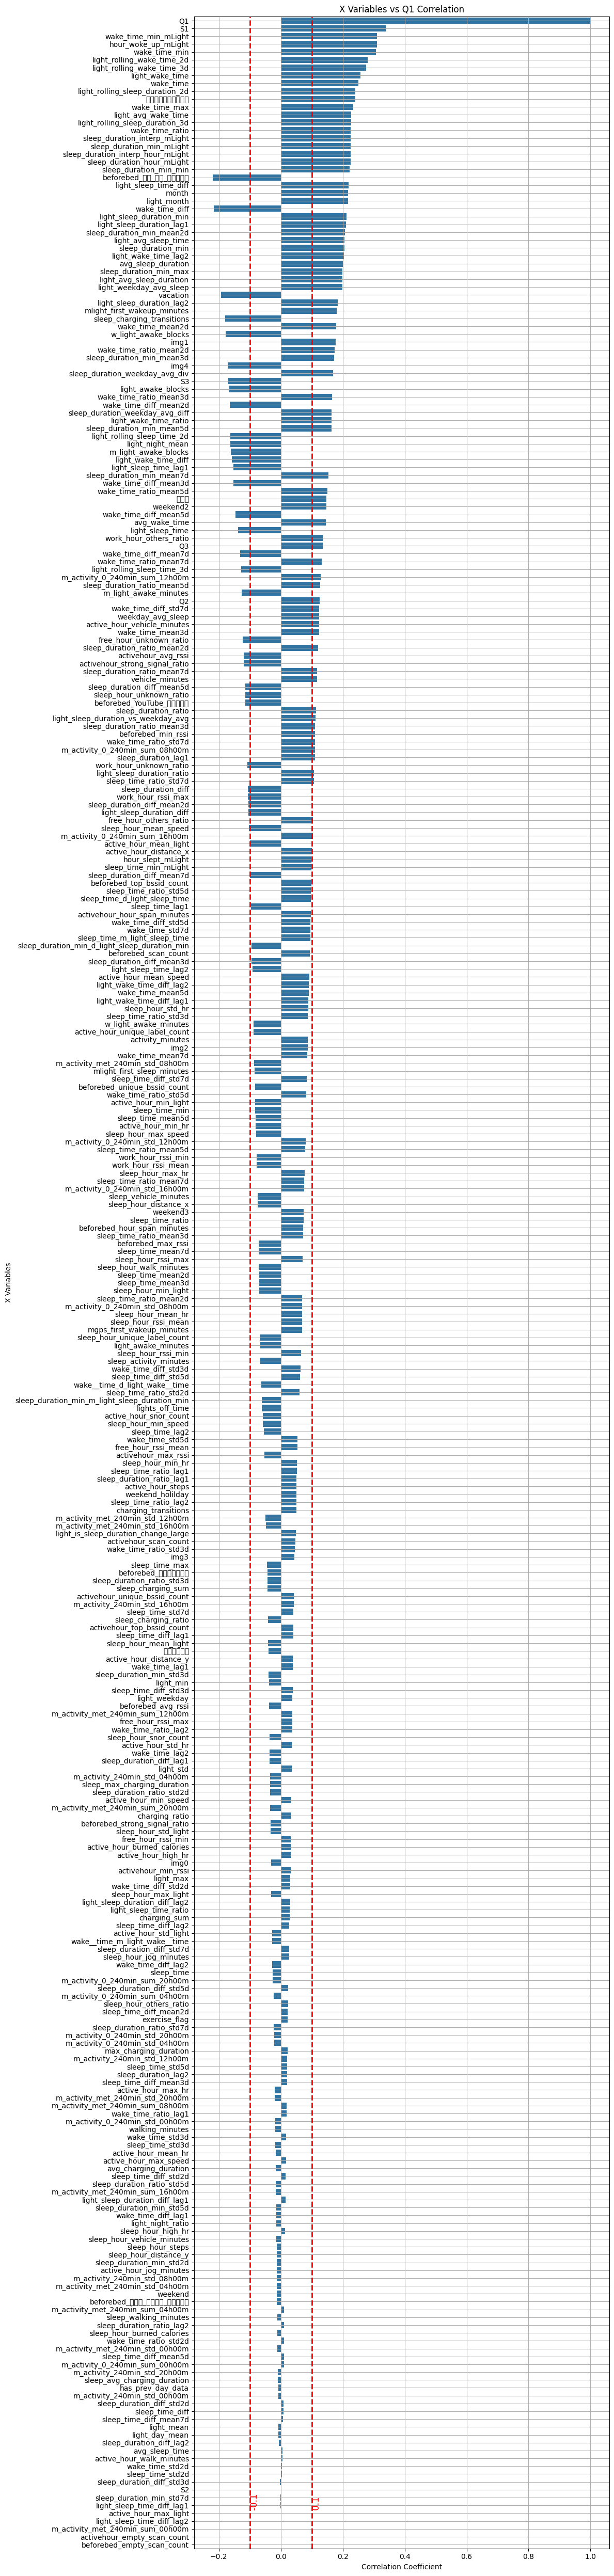

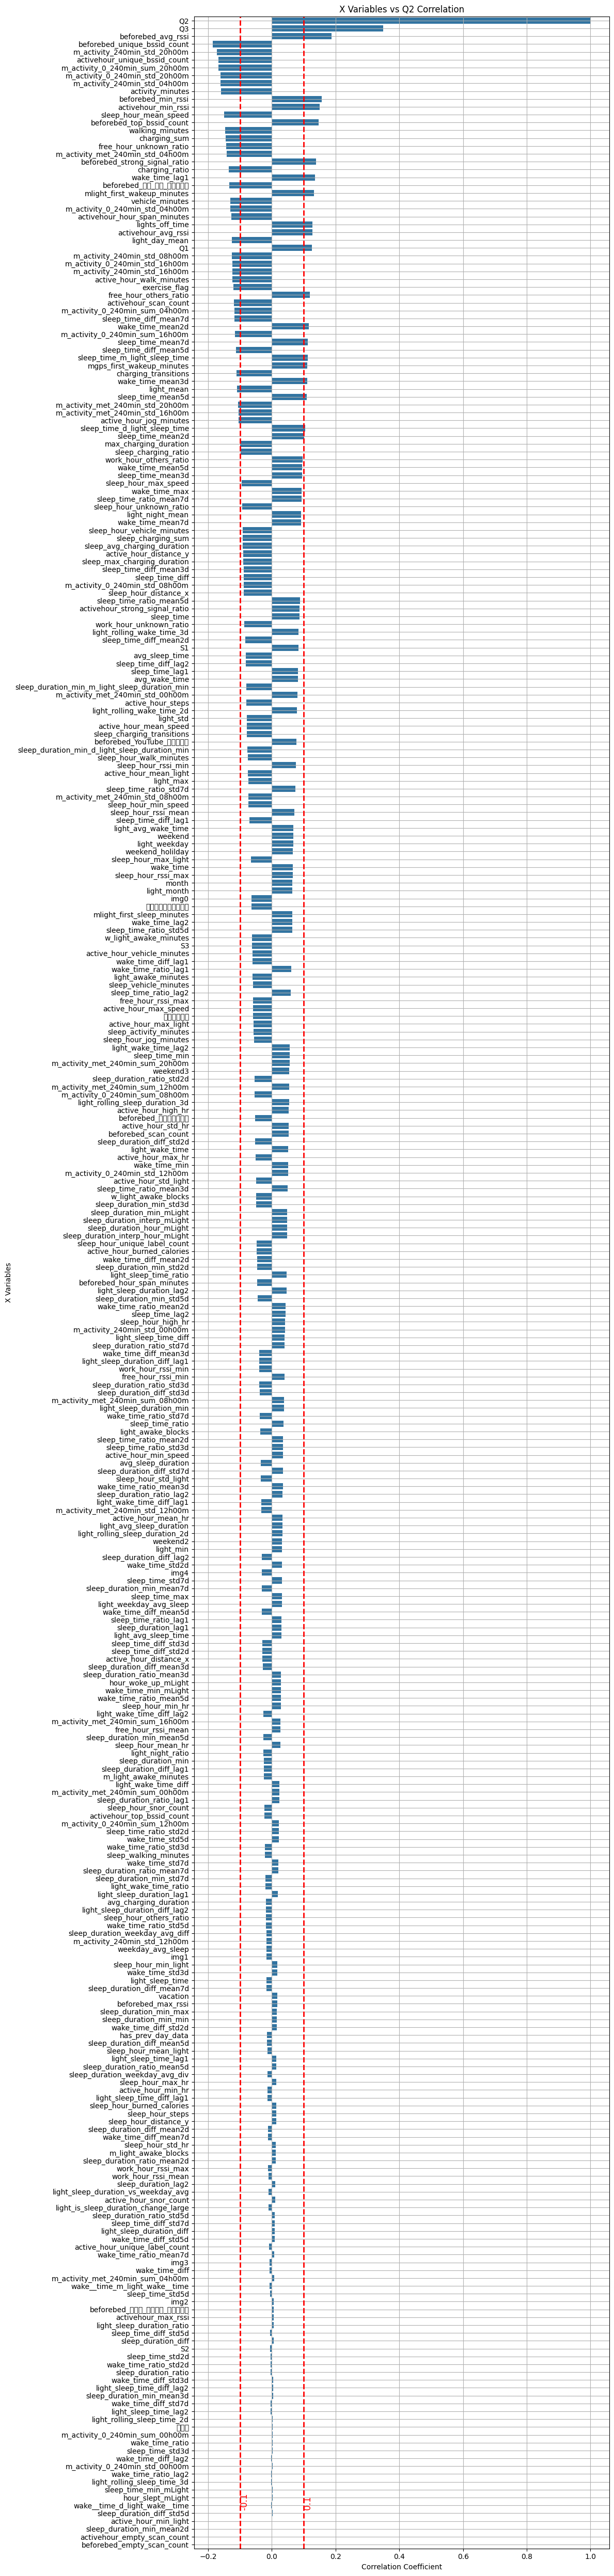

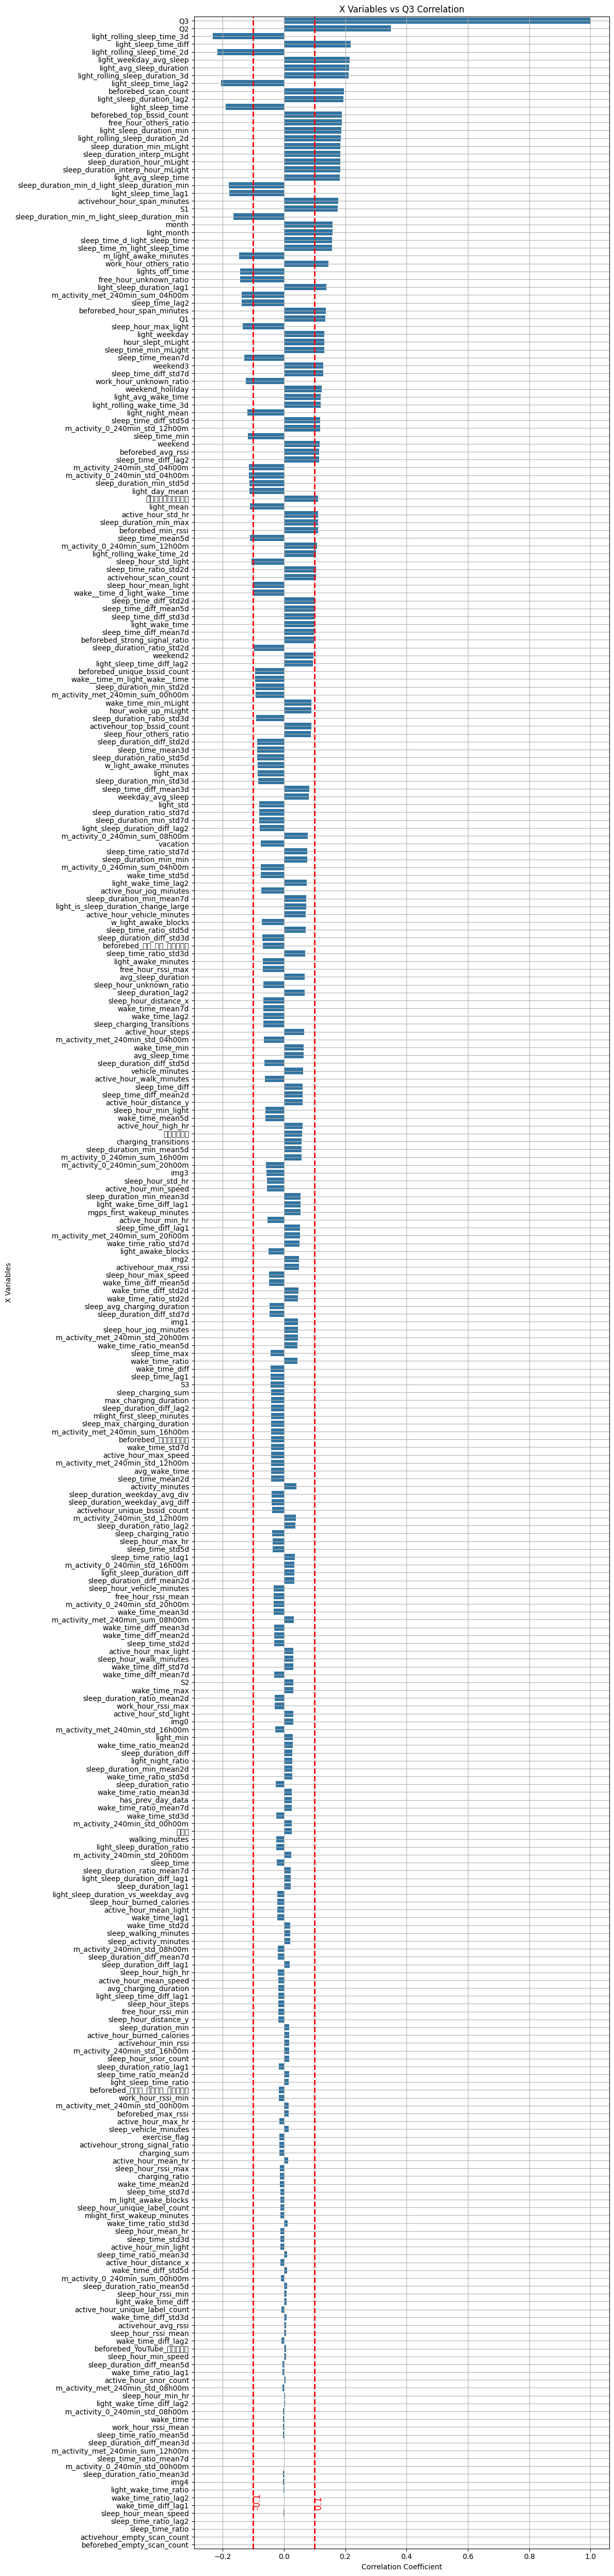

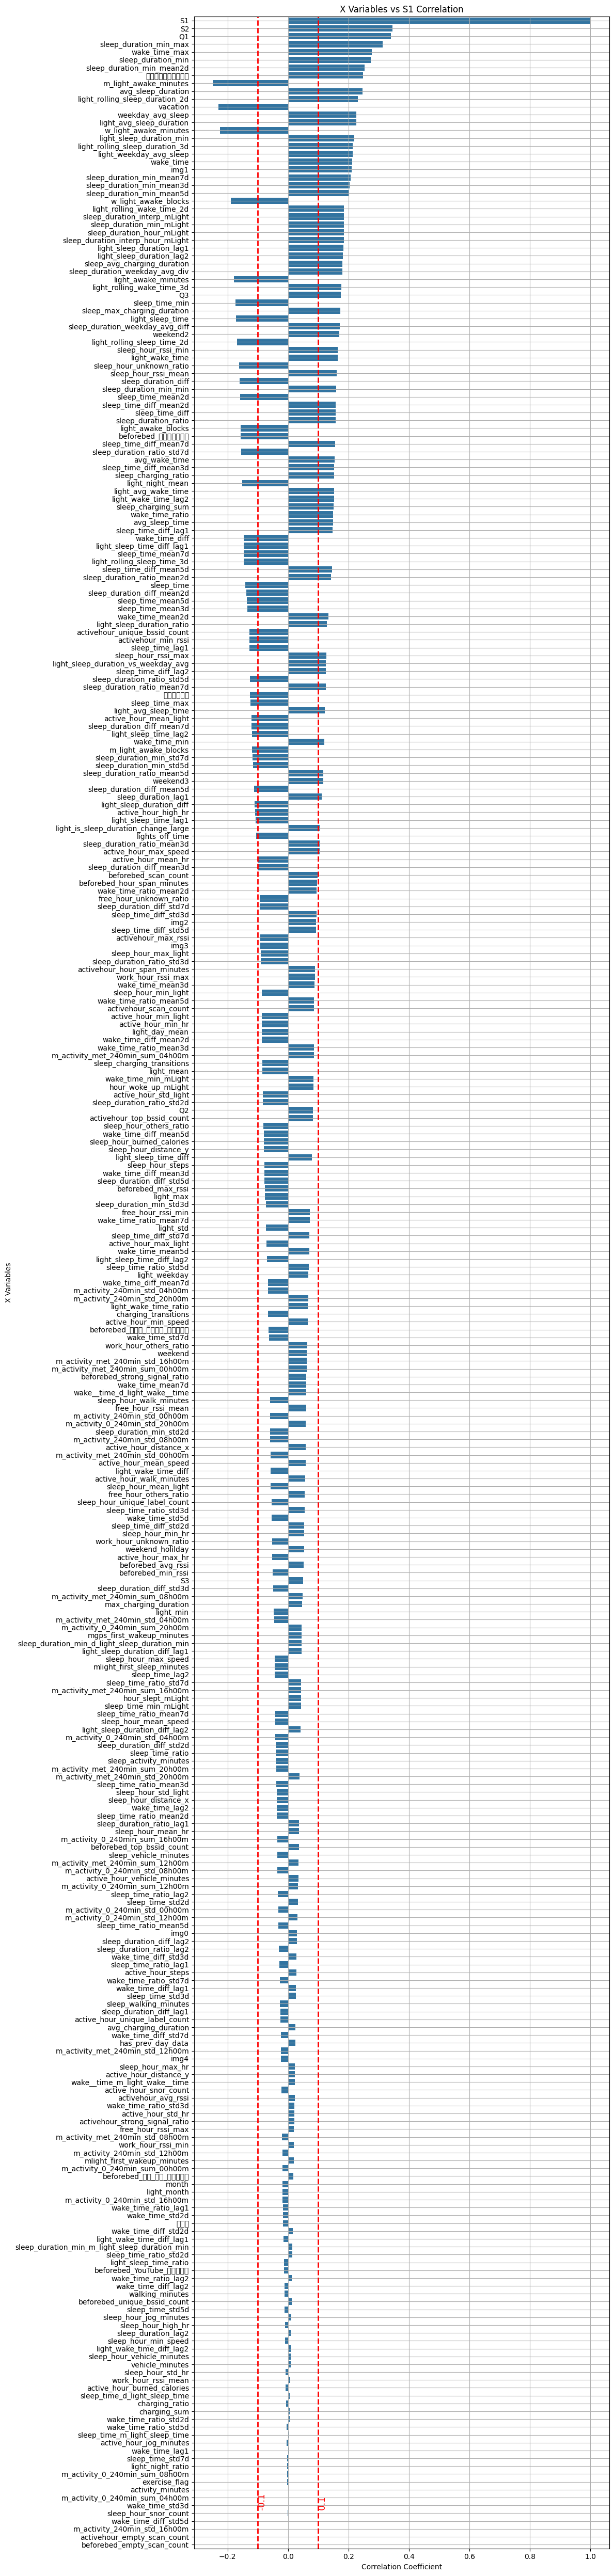

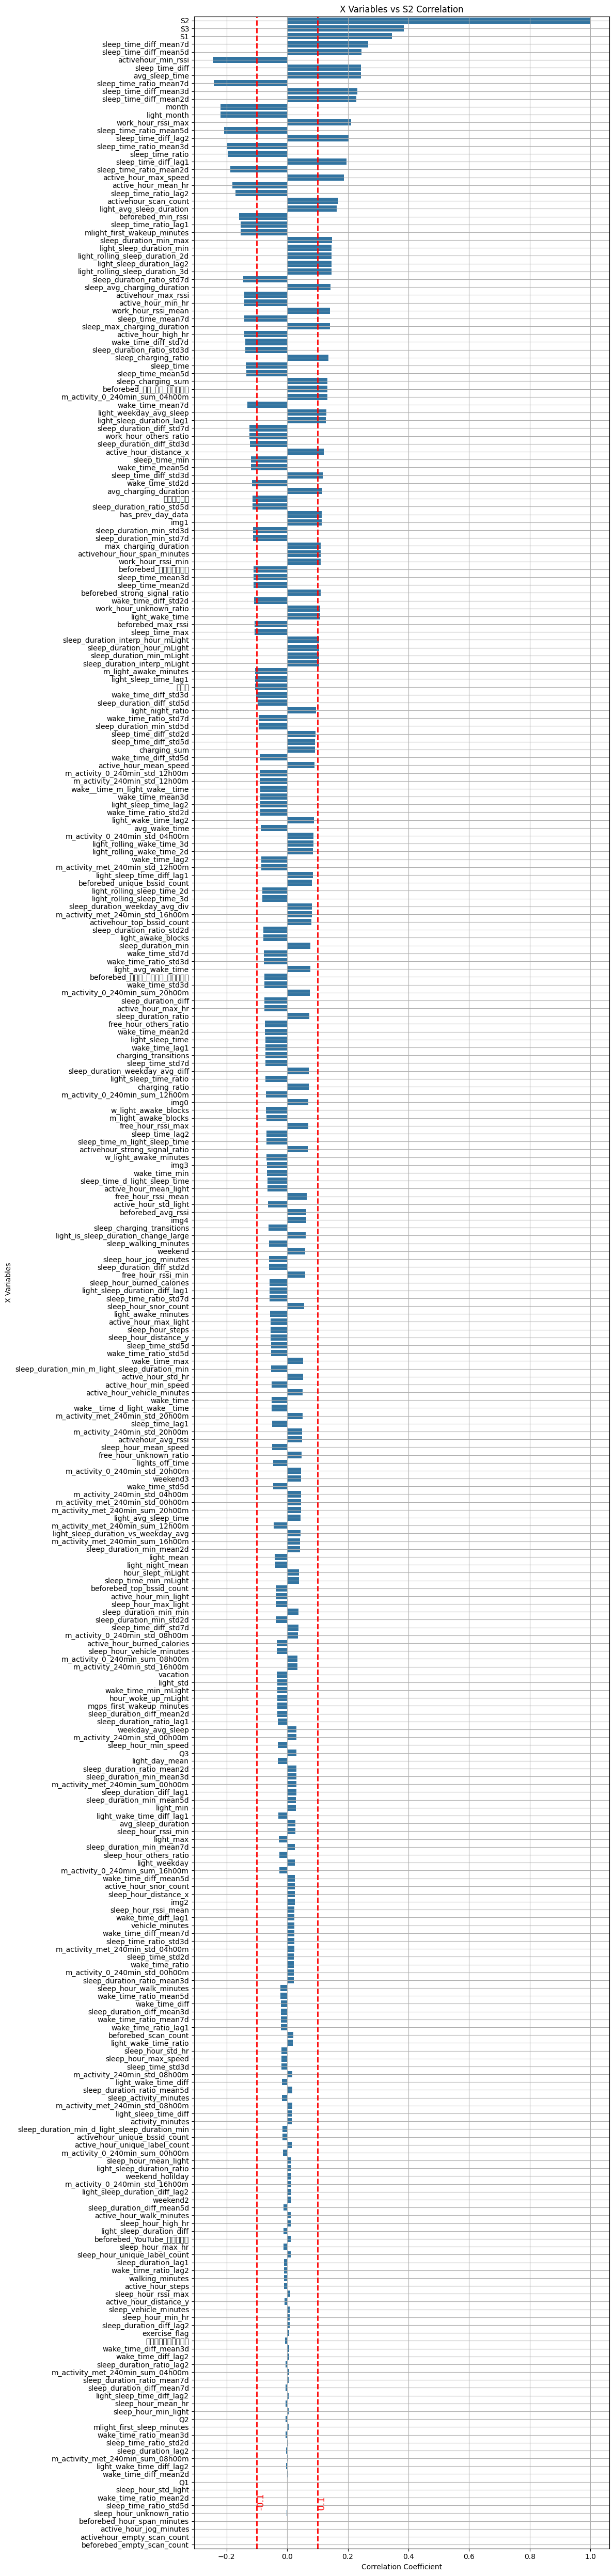

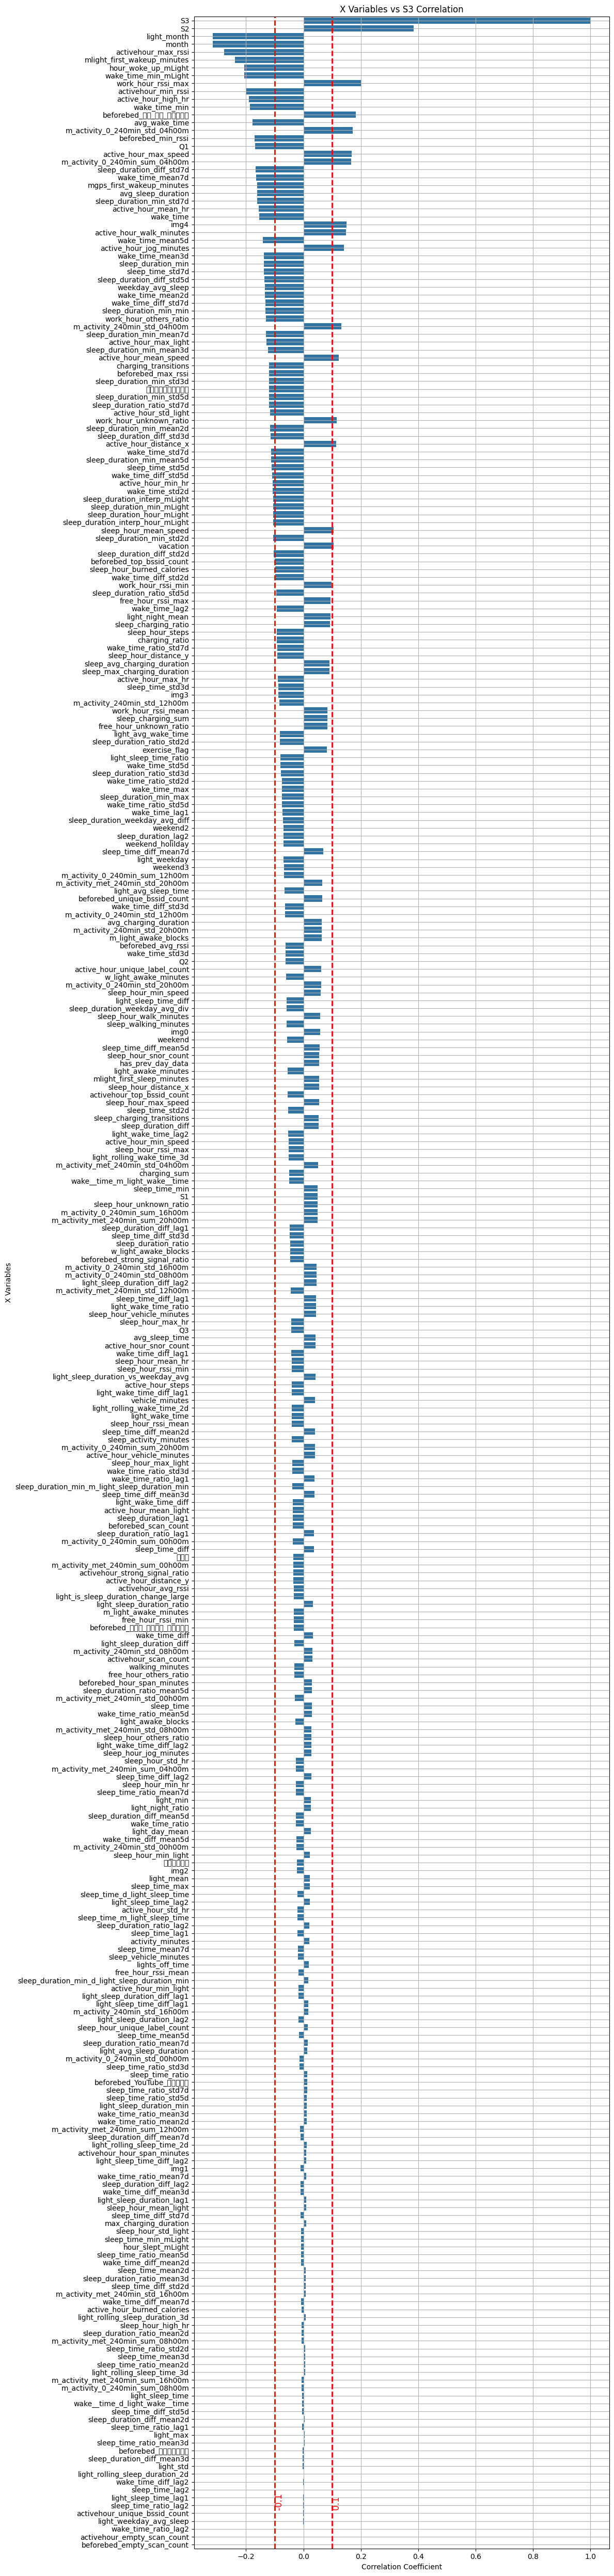

In [56]:
for i in ['Q1','Q2','Q3','S1','S2','S3']:

  # 상관계수 계산 (X 각 열과 Y 간)
  correlations = train.select_dtypes(include=['number']).corrwith(train[i])
  sorted_correlations = correlations.abs().sort_values(ascending=False)
  sorted_correlations_with_sign = correlations.loc[sorted_correlations.index]

  # 그래프 설정
  plt.figure(figsize=(12, 50))  # 높이를 늘려 100개 변수를 모두 표시
  sns.barplot(x=sorted_correlations_with_sign.values, y=sorted_correlations_with_sign.index)
  plt.title(f"X Variables vs {i} Correlation")
  plt.xlabel("Correlation Coefficient")
  plt.ylabel("X Variables")
  # 4. -0.1과 +0.1 기준선 추가
  plt.axvline(x=-0.1, color='red', linestyle='--', linewidth=2, zorder=2)
  plt.axvline(x=0.1, color='red', linestyle='--', linewidth=2, zorder=2)

  # 5. 기준선 라벨 추가 (옵션)
  plt.text(-0.1, len(sorted_correlations_with_sign) - 5, " -0.1", color='red', rotation=90, fontsize=12, va='bottom')
  plt.text(0.1, len(sorted_correlations_with_sign) - 5, " 0.1", color='red', rotation=90, fontsize=12, va='bottom')

  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [60]:
correlations = train.select_dtypes(include=['number']).corrwith(train['Q1'])
sorted_correlations = correlations.abs().sort_values(ascending=False)
sorted_correlations[sorted_correlations>0.1].index.tolist()

['Q1',
 'S1',
 'wake_time_min_mLight',
 'hour_woke_up_mLight',
 'wake_time_min',
 'light_rolling_wake_time_2d',
 'light_rolling_wake_time_3d',
 'light_wake_time',
 'wake_time',
 'light_rolling_sleep_duration_2d',
 '불끈시간부터기상시간',
 'wake_time_max',
 'light_avg_wake_time',
 'light_rolling_sleep_duration_3d',
 'wake_time_ratio',
 'sleep_duration_interp_mLight',
 'sleep_duration_min_mLight',
 'sleep_duration_interp_hour_mLight',
 'sleep_duration_hour_mLight',
 'sleep_duration_min_min',
 'beforebed_통화_전화_앱이용시간',
 'light_sleep_time_diff',
 'month',
 'light_month',
 'wake_time_diff',
 'light_sleep_duration_min',
 'light_sleep_duration_lag1',
 'sleep_duration_min_mean2d',
 'light_avg_sleep_time',
 'sleep_duration_min',
 'light_wake_time_lag2',
 'avg_sleep_duration',
 'sleep_duration_min_max',
 'light_avg_sleep_duration',
 'light_weekday_avg_sleep',
 'vacation',
 'light_sleep_duration_lag2',
 'mlight_first_wakeup_minutes',
 'sleep_charging_transitions',
 'wake_time_mean2d',
 'w_light_awake_blocks